# MACHINE LEARNING I
# 
# LAB ASSIGNMENT I: CLASSIFICATION

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the FICO_Dataset.csv dataset and extract conclusions, performing several classification methods properly explained.

---

In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
from neuralsens import partial_derivatives as ns
# Others
from mltools import classification_tools as CT
import math
from mltools import model_tools as MT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [2]:
warnings.filterwarnings("ignore")

---

## 1. Preparing the Dataset

First of all, we start by loading the dataset and taking a look at the first 10 rows, shape of the DataFrame and type of columns in order to understand the variables.

### STEP 1: IMPORT DATASET

In [4]:
### Load file --------------------------------------------
df2 = pd.read_csv('FICO_dataset_reduced_MOD.csv', sep = ";")
df2.head()

RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
0              1.0                    55                          33   
1              1.0                    61                           0   
2              1.0                    67                          53   
3              1.0                    66                          72   
4              1.0                    81                          51   

   AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
0              84                  144.0                   69.0   
1              41                   58.0                    0.0   
2              24                   66.0                   86.0   
3              73                  169.0                   91.0   
4             132                  333.0                   80.0   

   PercentInstallTrades  NumSatisfactoryTrades  NumTotalTrades  \
0                    43                   20.0            23.0   
1                    67                    2.0             7.0   
2                    44                    9.0             9.0   
3                    57                   28.0            30.0   
4                    25                   12.0            12.0   

   PercentTradesNeverDelq  MSinceMostRecentInqexcl7days  
0                      83                             0  
1                     100                             0  
2                     100                             0  
3                      93                             0  
4                     100                             0

In [5]:
print("Shape of the DataFrame = ", df2.shape)

Shape of the DataFrame =  (7442, 11)


As we can see, there are 11 variables. Of those 11, 10 are independent, including:

- **ExternalRiskEstimate**: A measure of borrower's riskiness based on consolidated external data sources.

- **NetFractionRevolvingBurden**: The proportion of an individual's current credit usage compared to their maximum allowed credit.

- **AverageMInFile**: The average duration, in months, of the trades in a borrower's credit file.

- **MSinceOldestTradeOpen**: The age, in months, of a borrower's oldest credit account.

- **PercentTradesWBalance**: The percentage of trades with positive balance. ?

- **PercentInstallTrades**: The percentage of a borrower's credit accounts that have fixed payment terms over a specified period.

- **NumSatisfactoryTrades**: Count of trades where a borrower has met obligations satisfactorily.

- **NumTotalTrades**: Number of Total Trades (total number of credit accounts).

- **MSinceMostRecentInqexcl7days**: Months since the last credit inquiry, ignoring the most recent week.

- **PercentTradesNeverDelq**: The percentage of a borrower's trades with no history of delinquency.

Therefore, the variable to be predicted is:

- **RiskPerformance**: Paid as negotiated flag (12-36 months). Class variable (0 or 1).

### STEP 2: CHECK OUT THE MISSING VALUES

In [6]:
### Info and type of variables & missing
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          7442 non-null   int64  
 2   NetFractionRevolvingBurden    7442 non-null   int64  
 3   AverageMInFile                7442 non-null   int64  
 4   MSinceOldestTradeOpen         7415 non-null   float64
 5   PercentTradesWBalance         7386 non-null   float64
 6   PercentInstallTrades          7442 non-null   int64  
 7   NumSatisfactoryTrades         7425 non-null   float64
 8   NumTotalTrades                7419 non-null   float64
 9   PercentTradesNeverDelq        7442 non-null   int64  
 10  MSinceMostRecentInqexcl7days  7442 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 639.7 KB


We can observe that there are several missing values. Most of them are in our response variable, so we have to delete those observations (impute values in that column could be dangerous because it will affect the results of all models). Appart from that, it is also necessary to change the type of this variable, and also we could reassign the type of the *float64* ones to *int64* but it's not mandatory.

In [7]:
### Basic removal of missing values
df = df2.dropna(subset=['RiskPerformance'], inplace=False) #Inplace for "really" elminiating the rows in the dataframe

#Check results
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5218 non-null   float64
 5   PercentTradesWBalance         5189 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5228 non-null   float64
 8   NumTotalTrades                5222 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


It seems that the rest of the missing values (around 100) belong to other variables. We could delete them, but we would lose information for the rest of values in the observations. So is that, we impute that missings with the k-nearest neighbors function from scikit-learn.

In [8]:
columns_with_missing_values = df.columns[df.isnull().any()].tolist()

imputer = KNNImputer(n_neighbors=10) #Number of neighbors could be changed

# Impute missing values
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5245 non-null   float64
 5   PercentTradesWBalance         5245 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5245 non-null   float64
 8   NumTotalTrades                5245 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


### STEP 3: ENCODE VARIABLES

In [9]:
#There are no categorical input variables

### Convert output variable to factor
df.RiskPerformance = df.RiskPerformance.astype('category')

### Convert float64 variables to int64
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].apply(lambda x: x.astype('int64'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5245 non-null   category
 1   ExternalRiskEstimate          5245 non-null   int64   
 2   NetFractionRevolvingBurden    5245 non-null   int64   
 3   AverageMInFile                5245 non-null   int64   
 4   MSinceOldestTradeOpen         5245 non-null   int64   
 5   PercentTradesWBalance         5245 non-null   int64   
 6   PercentInstallTrades          5245 non-null   int64   
 7   NumSatisfactoryTrades         5245 non-null   int64   
 8   NumTotalTrades                5245 non-null   int64   
 9   PercentTradesNeverDelq        5245 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 456.0 KB


### STEP 4: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

In [10]:
# Data types
df.describe()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
count           5245.000000                 5245.000000     5245.000000   
mean              71.103718                   34.584747       77.130219   
std               12.535667                   29.076478       33.535254   
min               -9.000000                   -9.000000       -9.000000   
25%               64.000000                    9.000000       57.000000   
50%               72.000000                   29.000000       75.000000   
75%               80.000000                   56.000000       94.000000   
max               93.000000                  232.000000      322.000000   

       MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
count            5245.000000            5245.000000           5245.000000   
mean              200.537464              65.599428             34.668255   
std                99.076681              22.654030             17.413723   
min                -9.000000              -9.000000             -9.000000   
25%               135.000000              50.000000             22.000000   
50%               185.000000              67.000000             33.000000   
75%               259.000000              82.000000             46.000000   
max               604.000000             100.000000            100.000000   

       NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
count            5245.000000     5245.000000             5245.000000   
mean               21.119161       22.823832               91.310391   
std                11.272021       12.206065               15.159203   
min                -9.000000       -9.000000               -9.000000   
25%                13.000000       15.000000               89.000000   
50%                20.000000       21.000000               97.000000   
75%                27.000000       30.000000              100.000000   
max                78.000000      100.000000              100.000000   

       MSinceMostRecentInqexcl7days  
count                   5245.000000  
mean                       2.186654  
std                        4.994205  
min                       -9.000000  
25%                        0.000000  
50%                        0.000000  
75%                        3.000000  
max                       24.000000

As we can see, there are negative values that stand out. According to the information given, there are 3 possible scenarios:

- **-9**: No Bureau Record or No Investigation.

- **-8**: No Usable/Valid Trades or Inquiries.

- **-7**: Condition not Met (e.g. No Inquiries, No Delinquencies).

Therefore, if a **-9** appears in any row, it should be replaced. Nonetheless, if we take a look at the *.csv* file, we can see that there are around 50 rows that all of the values for the independent variables are **-9**, so we can proceed by deleting those rows.

In [11]:
df = df[(df != -9).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5195 entries, 0 to 7391
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5195 non-null   category
 1   ExternalRiskEstimate          5195 non-null   int64   
 2   NetFractionRevolvingBurden    5195 non-null   int64   
 3   AverageMInFile                5195 non-null   int64   
 4   MSinceOldestTradeOpen         5195 non-null   int64   
 5   PercentTradesWBalance         5195 non-null   int64   
 6   PercentInstallTrades          5195 non-null   int64   
 7   NumSatisfactoryTrades         5195 non-null   int64   
 8   NumTotalTrades                5195 non-null   int64   
 9   PercentTradesNeverDelq        5195 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5195 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 451.6 KB


ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
count           5195.000000                 5195.000000     5195.000000   
mean              71.874687                   35.004235       77.959192   
std                9.812837                   28.898398       32.608875   
min               33.000000                   -8.000000        4.000000   
25%               64.000000                    9.000000       57.000000   
50%               72.000000                   30.000000       75.000000   
75%               80.000000                   56.000000       94.000000   
max               93.000000                  232.000000      322.000000   

       MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
count            5195.000000            5195.000000           5195.000000   
mean              202.554187              66.317421             35.088547   
std                97.385605              21.541998             16.959460   
min                -8.000000              -8.000000              0.000000   
25%               137.000000              50.000000             22.000000   
50%               186.000000              67.000000             33.000000   
75%               260.500000              82.000000             46.000000   
max               604.000000             100.000000            100.000000   

       NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
count            5195.000000     5195.000000             5195.000000   
mean               21.409047       23.130125               92.275842   
std                10.929992       11.856607               11.585244   
min                 0.000000        1.000000                0.000000   
25%                13.000000       15.000000               89.000000   
50%                20.000000       22.000000               97.000000   
75%                28.000000       30.000000              100.000000   
max                78.000000      100.000000              100.000000   

       MSinceMostRecentInqexcl7days  
count                   5195.000000  
mean                       2.294321  
std                        4.895500  
min                       -8.000000  
25%                        0.000000  
50%                        0.000000  
75%                        3.000000  
max                       24.000000

Besides, there are also around 50 observations (2 of them with this value repeated) in different variables having **-8** as a value. Due to the fact that this number implies that there are no valid trades, we delete those rows, as in the previous case. It could be possible also to impute them, but the few observations affected and all the work that has to be done in order to do it correctly (maybe searching for a variable with correlation to use regression or a deep understanding of the variable and its relationship with the rest of them) indicates that eliminating the rows may be a better solution.

In [12]:
df = df[(df != -8).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5145 non-null   category
 1   ExternalRiskEstimate          5145 non-null   int64   
 2   NetFractionRevolvingBurden    5145 non-null   int64   
 3   AverageMInFile                5145 non-null   int64   
 4   MSinceOldestTradeOpen         5145 non-null   int64   
 5   PercentTradesWBalance         5145 non-null   int64   
 6   PercentInstallTrades          5145 non-null   int64   
 7   NumSatisfactoryTrades         5145 non-null   int64   
 8   NumTotalTrades                5145 non-null   int64   
 9   PercentTradesNeverDelq        5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5145 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 447.3 KB


ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
count           5145.000000                 5145.000000     5145.000000   
mean              71.819048                   35.175510       77.829155   
std                9.802586                   28.869156       32.555655   
min               33.000000                    0.000000        4.000000   
25%               64.000000                    9.000000       57.000000   
50%               72.000000                   30.000000       75.000000   
75%               80.000000                   56.000000       94.000000   
max               93.000000                  232.000000      322.000000   

       MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
count            5145.000000            5145.000000           5145.000000   
mean              202.413605              66.280078             35.010496   
std                97.201973              21.480005             16.853058   
min                 6.000000               0.000000              0.000000   
25%               137.000000              50.000000             22.000000   
50%               186.000000              67.000000             33.000000   
75%               260.000000              82.000000             46.000000   
max               604.000000             100.000000             94.000000   

       NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
count            5145.000000     5145.000000             5145.000000   
mean               21.459475       23.181147               92.267444   
std                10.918579       11.851869               11.561419   
min                 0.000000        1.000000                0.000000   
25%                14.000000       15.000000               89.000000   
50%                20.000000       22.000000               97.000000   
75%                28.000000       30.000000              100.000000   
max                78.000000      100.000000              100.000000   

       MSinceMostRecentInqexcl7days  
count                   5145.000000  
mean                       2.374927  
std                        4.835027  
min                       -7.000000  
25%                        0.000000  
50%                        0.000000  
75%                        3.000000  
max                       24.000000

The last strange value is **-7**, which implies that the condition of the column is not met. As we can see, it only appears in the months since the most recent credit inquiry, meaning that there has never been an inquiry in that line of credit. We have again two options, but here it could be better to impute the values, because the degree of depth of understanding necessary for this and the rest of the variables is less than the previous case. 

The idea is to replace the values with an extremely (yet logical) high value, and add a binary column indicating if there has been an inquiry in the line of credit. Obviously this new variable would be used in nearly all the models of the assignment (in LDA and QDA is not possible). 

The maximum value is 24 months, so we can change all **-7** observations for **24** months. However, maybe the line of credit was opened after 24 months, so maybe it is better to convert the column into a categorical one. To prove this, we plot an histogram to observe its distribution.

Anyway, we will also change the -7 observations for 24 months in the cases it makes sense and for the maximum logical value in the rest of the cases. We do this, as in some models we will create in the future, it might be interesting to have only quantitative variables.

In [13]:
df.columns

df['MSinceMostRecentInqexcl7days'].describe()

count    5145.000000
mean        2.374927
std         4.835027
min        -7.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        24.000000
Name: MSinceMostRecentInqexcl7days, dtype: float64

In [14]:
df['MSinceMostRecentInqexcl7daysN']=df['MSinceMostRecentInqexcl7days']
     
for i in df['MSinceMostRecentInqexcl7daysN'].index:
    if df['MSinceMostRecentInqexcl7daysN'][i]==-7:
        df['MSinceMostRecentInqexcl7daysN'][i] = min(df['MSinceOldestTradeOpen'][i],24)
 

This variable 'MSinceMostRecentInqexcl7daysN' will be the one that will be used in the models that only include quantitative values

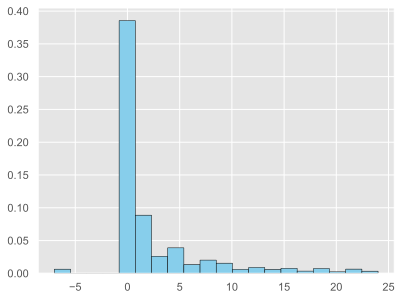

In [15]:
plt.hist(df['MSinceMostRecentInqexcl7days'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

We can see that the frequency is a lot higher in one or two of the values. For that reason, and bearing in mind the previous study with **-7**, we change this variable to a categorical one.

In [16]:
#Creation of the LessThan1Month dummy for future model purposes

df['lessthan1Month_num'] = 0
df.loc[df['MSinceMostRecentInqexcl7days'] < 1, 'lessthan1Month_num'] = 1

In [17]:
# Creation of the categorical variable MSinceMostRecentInqexcl7days
conditions = [
    (df['MSinceMostRecentInqexcl7days'] < 1) & (df['MSinceMostRecentInqexcl7days'] >= 0),
    (df['MSinceMostRecentInqexcl7days'] <= 6) & (df['MSinceMostRecentInqexcl7days'] >= 1),
    (df['MSinceMostRecentInqexcl7days'] <= 12) & (df['MSinceMostRecentInqexcl7days'] > 6),
    (df['MSinceMostRecentInqexcl7days'] > 12),
    (df['MSinceMostRecentInqexcl7days'] == -7)
]

choices = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']

df['MSinceMostRecentInqexcl7days'] = np.select(conditions, choices, default='Unknown')
df.MSinceMostRecentInqexcl7days = df.MSinceMostRecentInqexcl7days.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   RiskPerformance                5145 non-null   category
 1   ExternalRiskEstimate           5145 non-null   int64   
 2   NetFractionRevolvingBurden     5145 non-null   int64   
 3   AverageMInFile                 5145 non-null   int64   
 4   MSinceOldestTradeOpen          5145 non-null   int64   
 5   PercentTradesWBalance          5145 non-null   int64   
 6   PercentInstallTrades           5145 non-null   int64   
 7   NumSatisfactoryTrades          5145 non-null   int64   
 8   NumTotalTrades                 5145 non-null   int64   
 9   PercentTradesNeverDelq         5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days   5145 non-null   category
 11  MSinceMostRecentInqexcl7daysN  5145 non-null   int64   
 12  lessthan1Month_num             5145 non

After fixing all the strange values, we can proceed to plot some graphics searching for other outliers, and visualizing the distribution.

In [18]:
Independent_vars = df.columns[(df.columns != 'RiskPerformance')]
Independent_vars_cuant = df.columns[(df.columns != 'lessthan1Month_num') & (df.dtypes != 'category')]

# Definition of the rows and columns for the plot
num_rows = len(Independent_vars_cuant) // 2  #Now there are 10 cuantitative variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    axs[row, col].hist(df[var], bins=20, color='skyblue', edgecolor='black', density=True) #Number of bins could be changed
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In the penultimate histogram we can observe a similar behaviour to the variable `MSinceMostRecentInqexcl7daysN`, but here it could be more interesting to keep this variable as a quantitative one (for future models). For that reason, we use a BoxCox transformation for both variables.

In [19]:
from scipy.stats import boxcox

df['PercentTradesNeverDelq'] = boxcox((df['PercentTradesNeverDelq'] + 0.0001))[0] #To ensure that all data is positive
df['MSinceMostRecentInqexcl7daysN'] = boxcox((df['MSinceMostRecentInqexcl7daysN'] + 0.0001))[0] #To ensure that all data is positive

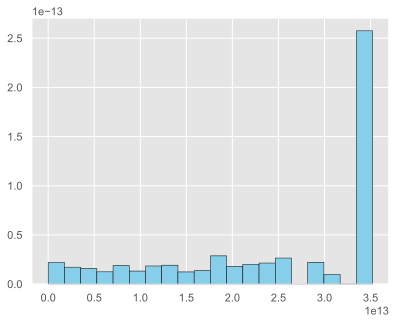

In [20]:
plt.hist(df['PercentTradesNeverDelq'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

This is the maximum normality we can get. Obviously it is not the desired, but we cannot use more transformations.

In the rest of the columns, we cannot see any clear outliers or strange observations. Therefore, we proceed representing several boxplots and scatterplots of the variables.

In [21]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.boxplot(x=df[var], ax=axs[row, col], color='skyblue')
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, there are several outliers and most of them are skewed distributions. Nonetheless, there are not strange enough to think about replacing or deleting them. To finish things off, we represent the 2 categorical variables, in order to spot strange behaviours.

In [22]:
num_rows = 1  #2 categorical variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Loop in charge of representing histograms
#for i, var in enumerate(['RiskPerformance', 'MSinceMostRecentInqexcl7days']):
#    col = i % num_cols
#    ax = axs[col]
#    df[var].value_counts(normalize=True).plot.bar(rot=0, xlabel=var, ax=ax, ylabel ='Frequency', color = 'Skyblue')
#    ax.tick_params(axis='x', labelsize=9)

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

The results are the expected, so we can continue.

### STEP 5: EXPLORATORY ANALYSIS

First, we are going to represent a brief study between the dependent variable `RiskPerformance` and the rest of all. We have several options, such as density curves, box plots, etc. Nevertheless, we are going to plot a group of violin plots, stip plots and histogram subplots based on the response variable (box plots and density curves contain the same information as the previous ones).

In [23]:
num_rows = len(Independent_vars_cuant) // 2  #Now there are 10 cuantitative variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.violinplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col])
#    axs[row, col].set_title(f'Violinplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [24]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.stripplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col], jitter=True)
#    axs[row, col].set_title(f'Stripplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [25]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.histplot(x=var, hue='RiskPerformance', data=df, ax=axs[row, col], kde=False, stat='probability')
#    axs[row, col].set_title(f'Histogram of {var} by Risk Performance')
#    axs[row, col].set_xlabel(var)
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

There are not independent quantitative variables with a strong relationship with our response variable, the clearest ones might be the first four (`ExternalRiskEstimate`, `NetFractionRevolvingBurden`, `AverageMInFile` and `MSinceOldestTradeOpen`), yet being a slight dependency.

AttributeError: 'float' object has no attribute 'startswith'

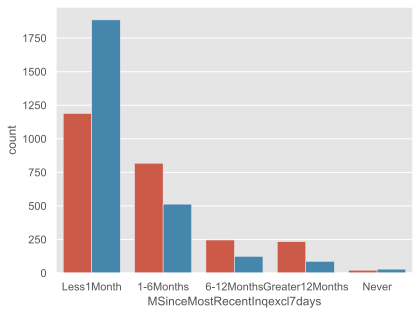

In [26]:
fig, ax = plt.subplots()
custom_order = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']
sns.countplot(x='MSinceMostRecentInqexcl7days', hue='RiskPerformance', data=df, order=custom_order)
ax.tick_params(axis='x', labelsize=10)
plt.xlabel('MSinceMostRecentInqexcl7days')
plt.ylabel('Count')
plt.title(f'Barplot of MSinceMostRecentInqexcl7days by Risk Performance')
plt.legend(title='RiskPerformance')

# Adjustment of design
plt.tight_layout()
# Graphic display
plt.show()

Observing the relationship between the two categorical variables we can deduce that there is a clear dependence, especially when the category is different from *Less1Month*.

In the previous section it could have been interesting to plot a pairplot, in order to spot outliers that the histograms and boxplots cannot mark. Nonetheless, with 9 quantitative variables (81 graphics), it is simply not possible to run the sentence along with the rest of the notebook. For that reason, after reviewing and searching for the most relationed variables with `RiskPerformance`, we represent a simplified pairplot.

In [27]:
# Scatterplot with the possibly most relationed variables with response
#plot = sns.pairplot(df.loc[:, ['RiskPerformance', 'ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 
#                        'MSinceOldestTradeOpen']], hue = 'RiskPerformance', height=2)
# Adjustment of design
#plt.tight_layout()
# Graphic display
#plt.show()

As we can see, there are no clear outliers, and the categories are really mixed.

The next task will be to study the possible relationship among independent variables, using a correlations plot and a pairplot, if possible. We have the same problem, so we study the pairplot for the most correlated variables.

In [28]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
#f = plt.figure()
#plt.matshow(df[Independent_vars_cuant].corr(), fignum=f.number, cmap='coolwarm')
#plt.xticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14, rotation=90)
#plt.yticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
#plt.show()

In [29]:
# Scatterplot with the most correlated variables. To run it, uncomment subsequent lines.

#sns.pairplot(df.loc[:, ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'MSinceOldestTradeOpen', 
#                               'NumSatisfactoryTrades', 'NumTotalTrades']], height=2)
#plt.tight_layout()
#plt.show()

We can appreciate that nearly all of them has little or no relationship with others. However, there are a few exceptions such as:

- **NumSatisfactoryTrades VS NumTotalTrades**: It seems pretty obvious because more trades will cause more satisfactory trades.

- **AverageMInFile VS MSinceOldestTradeOpen**: Similar to the previous one. More months in file is related with the months of your oldest trade.

- **ExternalRiskEstimate VS NetFractionRevolvingBurden**: It will be reasonable to have a lower `ExternalRiskEstimate` with a higher `NetFractionRevolvingBurden`, because it is easier for that specific sector to have paying problems.

### STEP 6: CHECK OUT FOR CLASS IMBALANCES

In [30]:
# Class count
df['RiskPerformance'] = df['RiskPerformance'].replace({0: "NO", 1: "YES"}) #Not paid/paid
df['RiskPerformance'].value_counts()

RiskPerformance
YES    2639
NO     2506
Name: count, dtype: int64

As we can see, our dependent variable is nearly perfectly balanced. So is that, we can move onto the next segment.

### STEP 7: SPLIT THE DATA INTO TRAINING AND TEST SETS

We apply the methods learnt in class to split the data into training and test sets, preserving the distribution of the response variable, doing copies of the subsets to store them and creating all the lists with the possible necessary inputs.

In [106]:
# Define input and output matrices
INPUTS = df.drop(columns=['RiskPerformance']).columns.tolist()
OUTPUT = 'RiskPerformance'
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

In [107]:
X_train.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  MSinceMostRecentInqexcl7daysN  \
7070                    1-6Months                       1.467896   
4049              Greater12Months                       2.657200   
3664                    1-6Months                       0.666009   
3008                    1-6Months                       0.000100   
6137                   Less1Month                     -16.491216   

      lessthan1Month_num  
7070                   0  
4049                   0  
3664                   0  
3008                   0  
6137                   1

In [108]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = y_test # We will call Y as output variable for simplicity

In [109]:
INPUTS_NUM = INPUTS.copy()
INPUTS_NUM.remove('MSinceMostRecentInqexcl7days') # Exclude categorical variable in order to apply OneHotEncoder
INPUTS_NUM_NOD = INPUTS_NUM.copy()
INPUTS_NUM_NOD.remove('lessthan1Month_num') # Exclude dummy variable in order to not have collinearity 
INPUTS_NUM_NOMS = INPUTS_NUM_NOD.copy()
INPUTS_NUM_NOMS.remove('MSinceMostRecentInqexcl7daysN') # Exclude quantitative variable in order to not have collinearity
INPUTS_CAT = ['MSinceMostRecentInqexcl7days'] # ategorical variable 

## 2. Training of Machine Learning models

### MODEL 1: LOGISTIC REGRESSION

We train our model for Logistic Regression. First, we normalize the variables to eliminate any advantages between our variables, ensuring that the model can learn fairly. Then, we train the model without any penalty, allowing it to learn without any restrictions. We will train the model by including all variables as input variables. Subsequently, we will train more models to enhance the obtained results.

In [147]:
# Inputs of the model. Change accordingly to perform variable selection

INPUTS_LR = INPUTS_NUM_NOMS + INPUTS_CAT
    
# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Model pipeline
pipe = Pipeline(steps=[('Prep', preprocessor), # Preprocess the variables when training the model
                        ('LogReg', LogisticRegression(penalty=None))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 

# Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


Now, we calculate the accuracy of our model by repeating the training process 10 times and calculating the mean.

In [148]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.734944960196537

In [149]:
CT.summaryLogReg(LogReg_fit.best_estimator_, X_train[INPUTS_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991037 -0.316301  0.054695  0.310723  0.947407

Coefficients:
                                              Estimate
Intercept                                    -0.375246
ExternalRiskEstimate                         -0.631557
NetFractionRevolvingBurden                    0.358653
AverageMInFile                               -0.268919
MSinceOldestTradeOpen                         0.034107
PercentTradesWBalance                        -0.006727
PercentInstallTrades                          0.140698
NumSatisfactoryTrades                        -0.248949
NumTotalTrades                               -0.014469
PercentTradesNeverDelq                       -0.206740
MSinceMostRecentInqexcl7days_6-12Months      -0.070556
MSinceMostRecentInqexcl7days_Greater12Months -0.216202
MSinceMostRecentInqexcl7days_Less1Month       0.791322
MSinceMostRecentInqexcl7days_Never            0.466527
                                    

As we can observe in the results, the deviance residual values could be improved, as they are not close enough to zero. When examining the coefficients, we can observe that the most significant variables are ExternalRiskEstimate, NetFractionRevolvingBurden, AverageMInFile, PercentInstallTrades, NumSatisfactoryTrades, PercentTradesNeverDelq and MSinceMostRecentInqexcl7days_Less1Month.

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training

dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

We now calculate the confusion matrix for the training dataset.

In [89]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1466  539
      YES  542 1569

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.95
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


We calculate the confusion matrix for the test dataset.

In [90]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_pred'],labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 340  161
      YES 130  398

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.08
Sensitivity: 0.75
Specificity: 0.68
Precision: 0.72
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.54
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


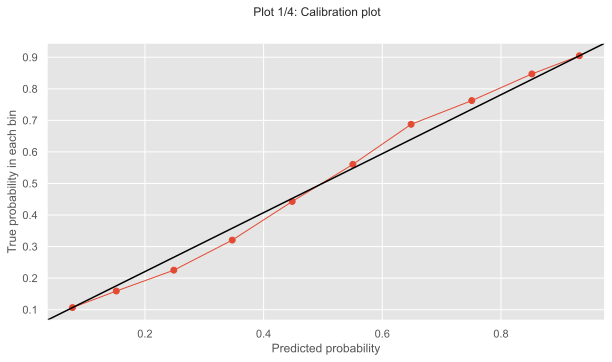

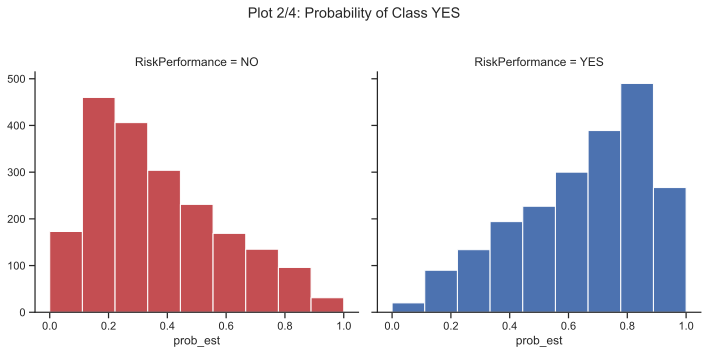

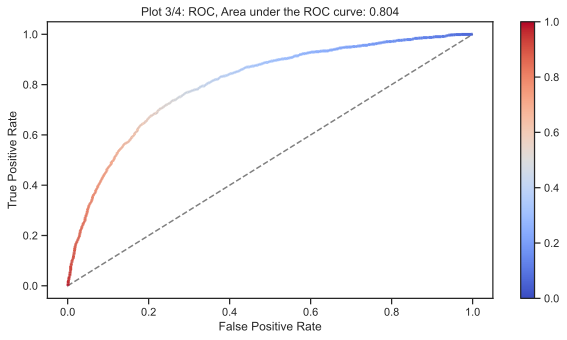

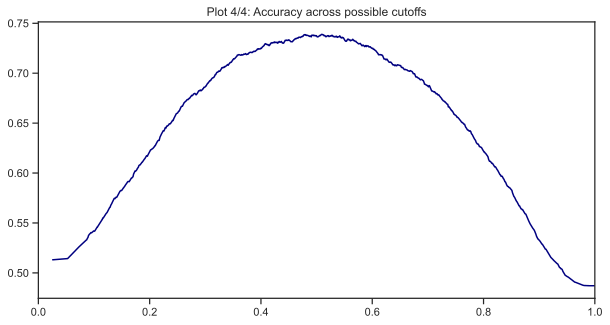

In [47]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass='YES')

As we can see in the plots, the result of this Logistic Regression model is underestimated, the ROC curve is not good enough

To improve the simplicity of our model, we will eliminate the following non-significant variables: MSinceOldestTradeOpen, PercentTradesWBalance, and NumTotalTrades. This simplification will make the model easier to understand and potentially improve its performance by reducing noise and complexity. We also removed the categorical variables except for one, 'MSinceMostRecentInqexcl7days_Less1Month.' Since the model was having trouble when removing only one of the categorical variables, we used the previously created significant variable 'lessthan1Month_num'.

In [128]:
# Inputs of the model. Change accordingly to perform variable selection

# Define input and output matrices

vars_eliminate = ['MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades', 'MSinceMostRecentInqexcl7daysN']
INPUTS2_LR = INPUTS_NUM.copy() # We use this subset due to the importance of the dummy Less1Month. It has been created for this model
for var in vars_eliminate:
    INPUTS2_LR.remove(var)

In [129]:
# Model pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), # Preprocess the variables when training the model
                        ('LogReg', LogisticRegression(penalty=None))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
# Train model
LogReg_fit.fit(X_train[INPUTS2_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [130]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS2_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7363983180969929

In [131]:
CT.summaryLogReg(LogReg_fit.best_estimator_, X_train[INPUTS2_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991196 -0.313489  0.054907  0.310481  0.938288

Coefficients:
                            Estimate
Intercept                   0.082970
ExternalRiskEstimate       -0.637079
NetFractionRevolvingBurden  0.351350
AverageMInFile             -0.246701
PercentInstallTrades        0.138539
NumSatisfactoryTrades      -0.252938
PercentTradesNeverDelq     -0.203882
lessthan1Month_num          0.405899
                            Estimate  Std. Err    t-value      Pr(>|t|) Signif
Intercept                   0.082970  0.036725   2.259252  2.386772e-02      *
ExternalRiskEstimate       -0.637079  0.068214  -9.339376  0.000000e+00    ***
NetFractionRevolvingBurden  0.351350  0.051169   6.866484  6.580292e-12    ***
AverageMInFile             -0.246701  0.043727  -5.641842  1.682401e-08    ***
PercentInstallTrades        0.138539  0.038155   3.630954  2.823752e-04    ***
NumSatisfactoryTrades      -0.252938  0.039920  -6.336

In [132]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_2_pred'] = LogReg_fit.predict(X_train[INPUTS2_LR])
dfTR_eval['Y_LR_2_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS2_LR])[:,0]
dfTR_eval['Y_LR_2_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS2_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_2_pred'] = LogReg_fit.predict(X_test[INPUTS2_LR])
dfTS_eval['Y_LR_2_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS2_LR])[:,0]
dfTS_eval['Y_LR_2_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS2_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  MSinceMostRecentInqexcl7daysN  \
7070                    1-6Months                       1.467896   
4049              Greater12Months                       2.657200   
3664                    1-6Months                       0.666009   
3008                    1-6Months                       0.000100   
6137                   Less1Month                     -16.491216   

      lessthan1Month_num RiskPerformance Y_MLP_pred  Y_MLP_prob_neg  \
7070                   0             YES         NO        0.602847   
4049                   0             YES         NO        0.871013   
3664                   0              NO         NO        0.716722   
3008                   0             YES        YES        0.259588   
6137                   1             YES        YES        0.054767   

      Y_MLP_prob_pos Y_LR_2_pred  Y_LR_2_prob_neg  Y_LR_2_prob_pos  
7070        0.397153          NO         0.623078         0.376922  
4049        0.128987          NO         0.884494         0.115506  
3664        0.283278          NO         0.715017         0.284983  
3008        0.740412         YES         0.275160         0.724840  
6137        0.945233         YES         0.038700         0.961300

In [133]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_2_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1460  545
      YES  541 1570

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.93
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [134]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_2_pred'], labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 342  159
      YES 130  398

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.1
Sensitivity: 0.75
Specificity: 0.68
Precision: 0.72
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.54
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


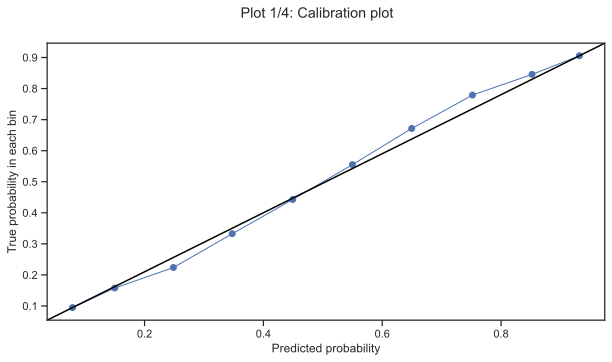

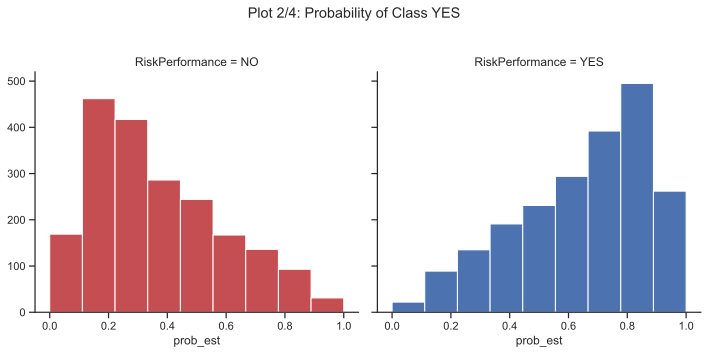

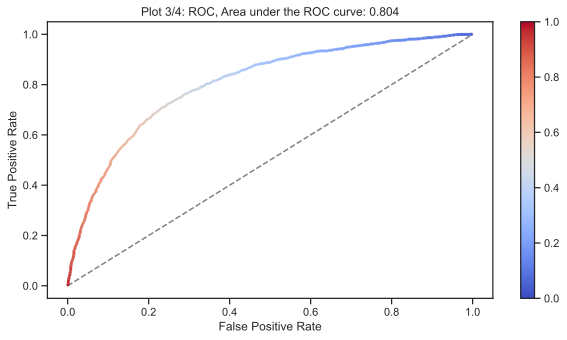

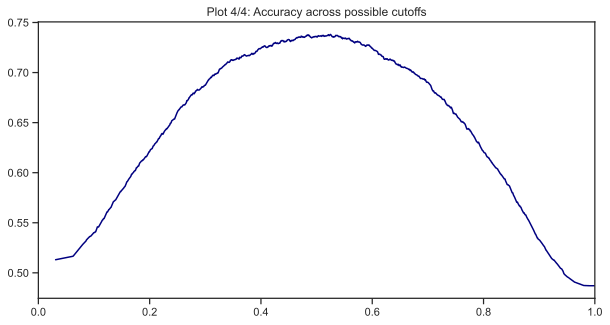

In [64]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS2_LR]), selClass='YES')

As we can observe now, the model's accuracy has improved, and the accuracy between training and test is closer. The model still has room for improvement.

Now, we select the significant variables and convert them into numerical values. Next, we choose the 10 initial variables and include them as quadratic terms. After training the model, we observe the presence of collinearities and NaN values. Therefore, we train a new model by selecting fewer quadratic variables and comparing the results. Finally, we obtain a model with the highest possible accuracy, and from that model, we retain only the significant variables. The following model is the result obtained. 

In [154]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR2_SQ = ['NumSatisfactoryTrades'] 
INPUTS_LR2_NUM = ['ExternalRiskEstimate', 'AverageMInFile', 'NetFractionRevolvingBurden', 'PercentTradesNeverDelq', 'PercentInstallTrades','lessthan1Month_num']
INPUTS_LR2 = INPUTS_LR2_NUM + INPUTS_LR2_SQ

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the numeric variables by scaling
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR2_NUM),
        ('sq', square_transformer, INPUTS_LR2_SQ), #Se aplica el square_transformer a los inputs escalares
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(fit_intercept=False, penalty=None))]) # Avoid using intercept when using polynomial features

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LogReg_fit_sq.fit(X_train[INPUTS_LR2], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [155]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7381003000023623

In [156]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_, X_train[INPUTS_LR2], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q      Max
0 -0.994108 -0.309023  0.046792  0.312544  0.94382

Coefficients:
                            Estimate
ExternalRiskEstimate       -0.632795
AverageMInFile             -0.242799
NetFractionRevolvingBurden  0.358968
PercentTradesNeverDelq     -0.203926
PercentInstallTrades        0.139615
lessthan1Month_num          0.403362
1                          -0.006402
NumSatisfactoryTrades      -0.336310
NumSatisfactoryTrades^2     0.096367
                            Estimate  Std. Err    t-value      Pr(>|t|) Signif
ExternalRiskEstimate       -0.632795  0.068392  -9.252514  0.000000e+00    ***
AverageMInFile             -0.242799  0.043700  -5.556072  2.759129e-08    ***
NetFractionRevolvingBurden  0.358968  0.051549   6.963651  3.315570e-12    ***
PercentTradesNeverDelq     -0.203926  0.053499  -3.811808  1.379539e-04    ***
PercentInstallTrades        0.139615  0.038328   3.642682  2.698122e-04    ***
lessthan1Month_num 

In [157]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_train[INPUTS_LR2])
dfTR_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,0]
dfTR_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_test[INPUTS_LR2])
dfTS_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,0]
dfTS_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ...  RiskPerformance  Y_MLP_pred  \
7070                    1-6Months  ...              YES          NO   
4049              Greater12Months  ...              YES          NO   
3664                    1-6Months  ...               NO          NO   
3008                    1-6Months  ...              YES         YES   
6137                   Less1Month  ...              YES         YES   

     Y_MLP_prob_neg Y_MLP_prob_pos  Y_LR_2_pred  Y_LR_2_prob_neg  \
7070       0.602847       0.397153           NO         0.623078   
4049       0.871013       0.128987           NO         0.884494   
3664       0.716722       0.283278           NO         0.715017   
3008       0.259588       0.740412          YES         0.275160   
6137       0.054767       0.945233          YES         0.038700   

     Y_LR_2_prob_pos  Y_LR_sq_pred  Y_LR_sq_prob_neg Y_LR_sq_prob_pos  
7070        0.376922            NO          0.646502         0.353498  
4049        0.115506            NO          0.893246         0.106754  
3664        0.284983            NO          0.731594         0.268406  
3008        0.724840           YES          0.288566         0.711434  
6137        0.961300           YES          0.033975         0.966025  

[5 rows x 22 columns]

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_sq_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1465  540
      YES  536 1575


In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_sq_pred'], labels=['NO','YES'])

In [ ]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2]), selClass='YES')

As we can see in the results, the model's accuracy improves. Also the area under the ROC curve has improved minimally. The results have generally improved, but only by a small margin.

### MODEL X: ElasticNet

Now we use the ElasticNet technique used in logistic regression to find the signficant variables. It's a combination of L1 (Lasso) and L2 (Ridge) regularization methods.

In [277]:
# Define las variables numéricas y categóricas

INPUTS_LR_E = INPUTS_NUM_NOMS + INPUTS_CAT

# Preprocesamiento para variables numéricas (escalamiento)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Preprocesamiento para variables categóricas (codificación one-hot)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# ColumnTransformer para aplicar transformaciones a las variables correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS),
        ('cat', categorical_transformer, INPUTS_CAT)
    ])

# Modelo de regresión logística con regularización Elastic Net
pipe = Pipeline(steps=[
    ('Prep', preprocessor),
    ('LogReg', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5))  # l1_ratio controla la mezcla entre L1 y L2
])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_elast = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 

# Entrena el modelo
LogReg_fit_elast.fit(X_train[INPUTS_LR_E], y_train)

print("Logistic Regression with ElasticNet Trained")

Logistic Regression with ElasticNet Trained


In [278]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_elast, X_train[INPUTS_LR_E], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7344571610800086

In [279]:
CT.summaryLogReg(LogReg_fit_elast, X_train[INPUTS_LR_E], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q      Max
0 -0.990963 -0.316466  0.055069  0.311509  0.94624

Coefficients:
                                              Estimate
Intercept                                    -0.373384
ExternalRiskEstimate                         -0.630738
NetFractionRevolvingBurden                    0.356071
AverageMInFile                               -0.265232
MSinceOldestTradeOpen                         0.029770
PercentTradesWBalance                        -0.003468
PercentInstallTrades                          0.139158
NumSatisfactoryTrades                        -0.248356
NumTotalTrades                               -0.013345
PercentTradesNeverDelq                       -0.206395
MSinceMostRecentInqexcl7days_6-12Months      -0.062547
MSinceMostRecentInqexcl7days_Greater12Months -0.203602
MSinceMostRecentInqexcl7days_Less1Month       0.787436
MSinceMostRecentInqexcl7days_Never            0.358923
                                      

As we can see in the previous results, the significant variables are 'ExternalRiskEstimate,' 'NetFractionRevolvingBurden,' 'AverageMInFile,' 'PercentInstallTrades,' 'NumSatisfactoryTrades,' 'PercentTradesNeverDelq,' and 'MSinceMostRecentInqexcl7days_Less1Month.' These significant variables, obtained using ElasticNet, align with the logistic regression method conducted earlier.

### MODEL 2: DISCRIMINANT ANALYSIS (DA)

Before entering the next model prediction study (k-nn), we try another method used in prediction, but not covered in class. This method is called discriminant analysis, and it is mainly used in certain situations:

- When the response variable classes are clearly divided. In this case, logistic regression could be extremely unstable.
- If the sample size is small and the independent variables are distributed approximately as a normal, DA could be more stable.
- Thirdly, it is more used when the response variable is not dichotomous, instead of multivariable logistic regression.

Therefore, it seems a worse prediction method than the previous one, but let's check it.

Before starting, it is important to give a brief definition and explanation of its functioning. After that, we start by testing the normality of the predictors.

Discriminant Analysis is a classification technique whose objective is to obtain a function (or set) that could classify new observations by the nearest centroid and separate the classes, using a set of discriminant functions (usually linear or quadratic). It is important to point out that independency of dependent variables is recommended, as well as in most of the other methods.

In [280]:
from scipy.stats import normaltest 

# Dictionary to store normality test results
normality_results = {}

# Check normality for each feature
for var in Independent_vars_cuant:
    normality_results[var] = normaltest(df[var]).pvalue > 0.05 #Shapiro is better for smaller samples

# normality_results dictionary will indicate whether each feature is normally distributed or not
print(normality_results)


{'ExternalRiskEstimate': False, 'NetFractionRevolvingBurden': False, 'AverageMInFile': False, 'MSinceOldestTradeOpen': False, 'PercentTradesWBalance': False, 'PercentInstallTrades': False, 'NumSatisfactoryTrades': False, 'NumTotalTrades': False, 'PercentTradesNeverDelq': False, 'MSinceMostRecentInqexcl7daysN': False}


In [281]:
from scipy.stats import probplot

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop to create Q-Q plots
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
    
    # Create Q-Q plot for the variable
#    probplot(df[var], plot=axs[row, col], fit=True)
    
#    axs[row, col].set_title(f'Q-Q Plot of {var}')
#    axs[row, col].set_xlabel('Theoretical Quantiles')
#    axs[row, col].set_ylabel('Sample Quantiles')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, the predictors are not normally distributed, neither analytically nor graphically. Therefore, the results obtained may be worse or less precise than others using K-Nearest Neighbors (KNN) or Support Vector Machine (SVM). Still, we will check the outputs.

In [282]:
from scipy.stats import boxcox

X_DA = X.copy()

# Box-Cox transformation to the predictors 
for var in Independent_vars_cuant[(Independent_vars_cuant != 'PercentTradesNeverDelq') & 
                                  (Independent_vars_cuant != 'MSinceMostRecentInqexcl7daysN')]:
    # We add 0.0001 to ensure that they are all positive variables
    X_DA[var] = boxcox(X_DA[var] + 0.0001)[0]

# Split for normalized data. We need a new one because normalizing after the split leads to errors in the X_test data frame,
# due to the lack of observations
X_train_DA, X_test_DA, y_train, y_test = train_test_split(X_DA, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y


In [283]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LDA = Independent_vars_cuant 

#ModLDA = LinearDiscriminantAnalysis()
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LDA',LinearDiscriminantAnalysis())]) # Model to use in the pipeline

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LDA_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LDA_fit.fit(X_train_DA[INPUTS_LDA], y_train);

print("Linear Discriminant Analysis Trained")

Linear Discriminant Analysis Trained


In [284]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LDA_fit, X_train_DA[INPUTS_LDA], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7332441594028299

In [285]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LDA_pred'] = LDA_fit.predict(X_train_DA[INPUTS_LDA])
dfTR_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_train_DA[INPUTS_LDA])[:,0]
dfTR_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_train_DA[INPUTS_LDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LDA_pred'] = LDA_fit.predict(X_test_DA[INPUTS_LDA])
dfTS_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_test_DA[INPUTS_LDA])[:,0]
dfTS_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_test_DA[INPUTS_LDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ...  RiskPerformance  Y_LR_pred  \
7070                    1-6Months  ...              YES         NO   
4049              Greater12Months  ...              YES         NO   
3664                    1-6Months  ...               NO         NO   
3008                    1-6Months  ...              YES        YES   
6137                   Less1Month  ...              YES        YES   

     Y_LR_prob_neg Y_LR_prob_pos  Y_LR_sq_pred  Y_LR_sq_prob_neg  \
7070      0.612584      0.387416            NO          0.646502   
4049      0.901065      0.098935            NO          0.893246   
3664      0.704087      0.295913            NO          0.731594   
3008      0.267271      0.732729           YES          0.288566   
6137      0.038554      0.961446           YES          0.033975   

     Y_LR_sq_prob_pos  Y_LDA_pred  Y_LDA_prob_neg Y_LDA_prob_pos  
7070         0.353498          NO        0.644385       0.355615  
4049         0.106754          NO        0.926528       0.073472  
3664         0.268406          NO        0.696809       0.303191  
3008         0.711434         YES        0.291566       0.708434  
6137         0.966025         YES        0.041659       0.958341  

[5 rows x 22 columns]

In [286]:
#Confusion matrix for Linear Discriminant Analysis
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LDA_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1459  546
      YES  542 1569

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.93
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [287]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LDA_pred'], labels=['NO', 'YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 340  161
      YES 127  401

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.05
Sensitivity: 0.76
Specificity: 0.68
Precision: 0.73
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


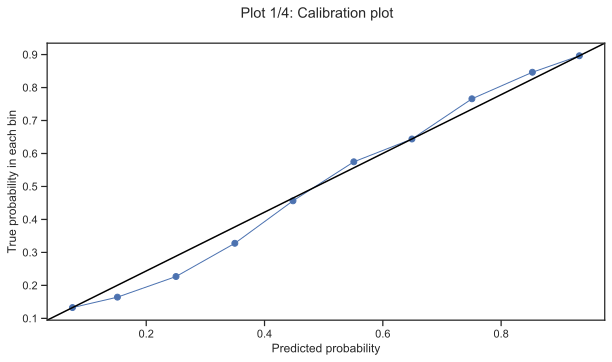

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


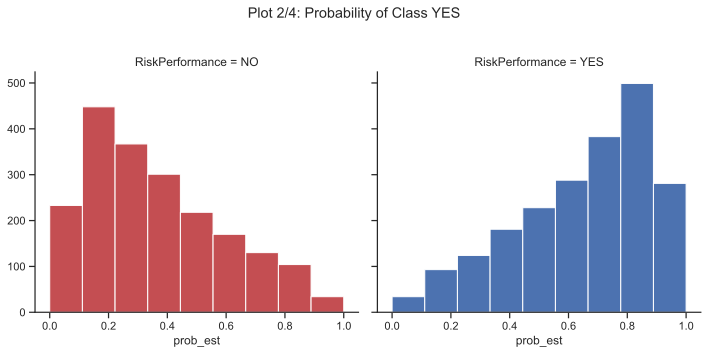

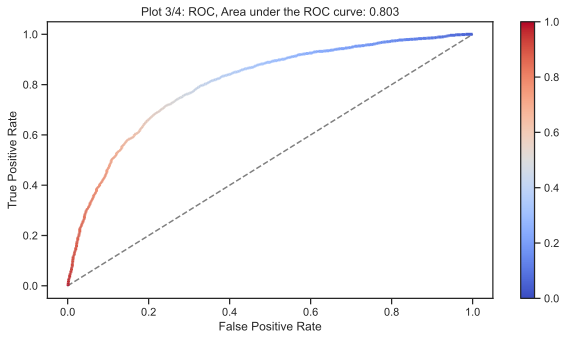

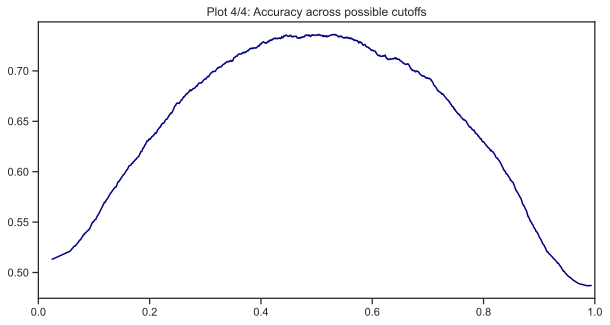

In [288]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LDA_fit.predict_proba(X_train_DA[INPUTS_LDA]), selClass='YES')

The results are pretty similar to logistic regression (a little bit worse unless the test's specificity), indicating that probably none of them is good enough to predict our response variable. We now try using quadratic discriminant analysis, searching for better results.

In [289]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_QDA = Independent_vars_cuant 

#ModQDA = QuadraticDiscriminantAnalysis()
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('QDA',QuadraticDiscriminantAnalysis())]) # Model to use in the pipeline

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
QDA_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
QDA_fit.fit(X_train_DA[INPUTS_QDA], y_train);

print("Quadratic Discriminant Analysis Trained")

Quadratic Discriminant Analysis Trained


In [290]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(QDA_fit, X_train_DA[INPUTS_QDA], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.723769281647887

In [291]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_QDA_pred'] = QDA_fit.predict(X_train_DA[INPUTS_QDA])
dfTR_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_train_DA[INPUTS_QDA])[:,0]
dfTR_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_train_DA[INPUTS_QDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_QDA_pred'] = QDA_fit.predict(X_test_DA[INPUTS_QDA])
dfTS_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_test_DA[INPUTS_QDA])[:,0]
dfTS_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_test_DA[INPUTS_QDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ...  Y_LR_prob_pos  Y_LR_sq_pred  \
7070                    1-6Months  ...       0.387416            NO   
4049              Greater12Months  ...       0.098935            NO   
3664                    1-6Months  ...       0.295913            NO   
3008                    1-6Months  ...       0.732729           YES   
6137                   Less1Month  ...       0.961446           YES   

     Y_LR_sq_prob_neg Y_LR_sq_prob_pos  Y_LDA_pred  Y_LDA_prob_neg  \
7070         0.646502         0.353498          NO        0.644385   
4049         0.893246         0.106754          NO        0.926528   
3664         0.731594         0.268406          NO        0.696809   
3008         0.288566         0.711434         YES        0.291566   
6137         0.033975         0.966025         YES        0.041659   

     Y_LDA_prob_pos  Y_QDA_pred  Y_QDA_prob_neg Y_QDA_prob_pos  
7070       0.355615          NO        0.510157       0.489843  
4049       0.073472          NO        0.900102       0.099898  
3664       0.303191          NO        0.668414       0.331586  
3008       0.708434         YES        0.361395       0.638605  
6137       0.958341         YES        0.021048       0.978952  

[5 rows x 25 columns]

In [292]:
#Confusion matrix for Quadratic Discriminant Analysis Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_QDA_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1355  650
      YES  471 1640



Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.78
Specificity: 0.68
Precision: 0.74
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.4
Detection prevalence: 0.56
Balanced accuracy: 0.73
F1 Score: 0.71
Positive label: NO


In [293]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_QDA_pred'], labels=['NO', 'YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 322  179
      YES 122  406

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.41
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.77
Specificity: 0.64
Precision: 0.73
Recall: 0.64
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.57
Balanced accuracy: 0.71
F1 Score: 0.68
Positive label: NO


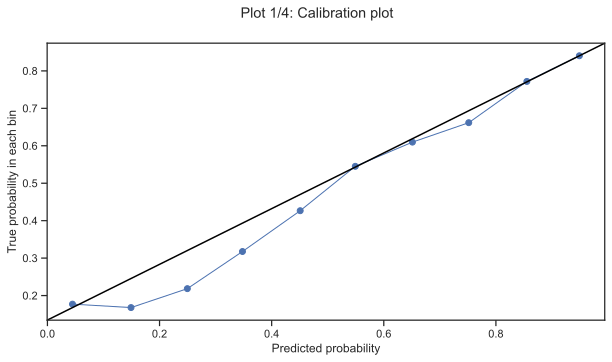

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


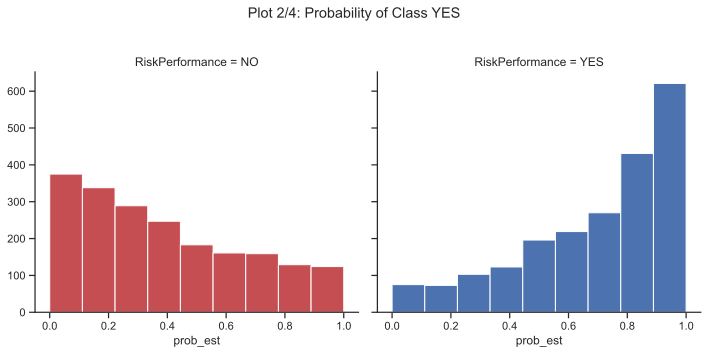

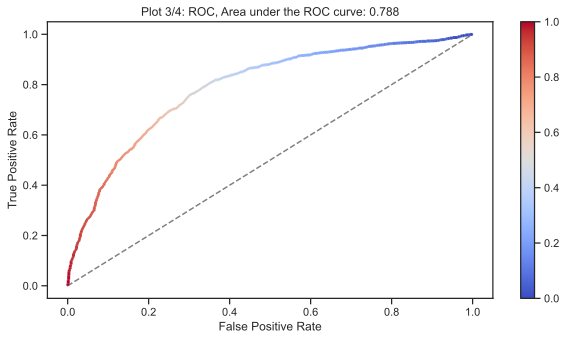

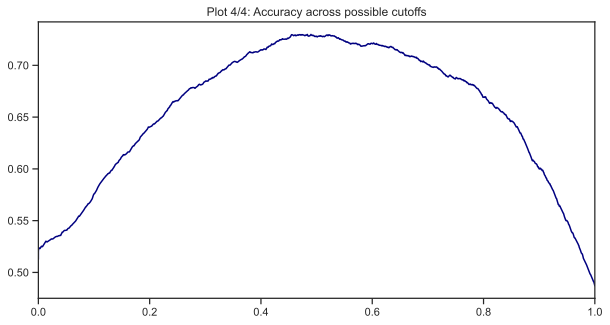

In [294]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], QDA_fit.predict_proba(X_train_DA[INPUTS_QDA]), selClass='YES')

We observe that the results are even worse, especially for the classification of *NO* class in `RiskPerformance`. Moreover, the Mcnemar's Test P-Value = 0.0 for both training and test, indicating that at least one model from CV has significantly different errors with the others, so it is not valid. Besides, we observe that in both models they have clearly higher values for sensitivity, and we are not interested in giving one of them more importance than the other.

### MODEL 3: K-NEAREST NEIGHBORS (KNN)

We move on to training a K-Nearest-Neighbours Model. The idea behind this algorithm is quite simple, however there are going to be a few characteristics of it that we need to work with carefully. 

In the previous models we have studied, there was no hyperparameter to consider, however this time, we will need to calculate(through CV) the number of neighbours that will turn out to produce the most accurate model we can get.

Unlike the two previous methods, where the own algorithm worked towards discovering which are the most meaningful variables in order to explain the variance in our response, in this case, the KNN gives equal importance to all the variables we include in the model. Due to that, we will have to study in more detail which variables are not being helpful, and adding noise to our model, as those will have a huge impact in our model.

However, we start by training an algorithm with all our variables and after it, we will decide if it is a good idea to remove any variable. We are going to train several models with different values of K(Number of neighbours considered), and analyze the results of accuracy of each model. All these values will be odd as this way we avoid draws between the 2 classes of our dependent variable. 

The other hyperparameter that takes part in the model is the number of folds we use in the CV, but for the whole document we will keep this value in 10.

In [215]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_KNN = INPUTS.copy()
INPUTS_KNN.remove('MSinceMostRecentInqexcl7days')

INPUTS_KNN=INPUTS_KNN + ['MSinceMostRecentInqexcl7daysN'] 

X = df[INPUTS_KNN]

# Split again including the numeric variable
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

 


## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(9,559,10)} #Number of neighbors
 
# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier( ))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("kNN Trained")
 

kNN Trained


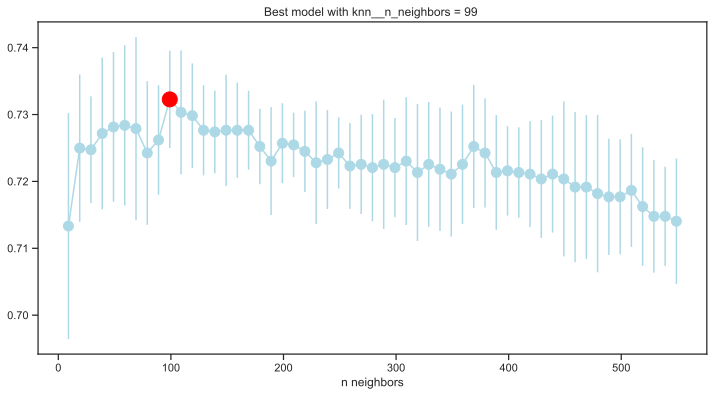

In [216]:
MT.plotModelGridError(knn_fit)

In [217]:

dfTR_KNN_eval = X_train.copy()
dfTR_KNN_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity
dfTS_KNN_eval = X_test.copy()
dfTS_KNN_eval["RiskPerformance"] = y_test # We will call Y as output variable for simplicity

print(dfTR_KNN_eval)

## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_KNN_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_KNN_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_KNN_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_KNN_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_KNN_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_KNN_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

      ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   
...                    ...                         ...             ...   
2661                    79                          66              91   
3536                    68                          75              55   
6248                    85                           1             109   
6348                    66                          23              94   
2352                    66                          49              96   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216        

 As we can see, we obtain that the optimal KNN model that includes all the possible variables considers 139 neighnbors. which feels like a pretty reasonable value considering the amount of data. Besides that, we obtain an accuracy value of between 0.73 and 

In [218]:
CT.confusion_matrix(dfTR_KNN_eval['RiskPerformance'], dfTR_KNN_eval['Y_knn_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1508  497
      YES  603 1508

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.71
Specificity: 0.75
Precision: 0.71
Recall: 0.75
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.49
Balanced accuracy: 0.73
F1 Score: 0.73
Positive label: NO


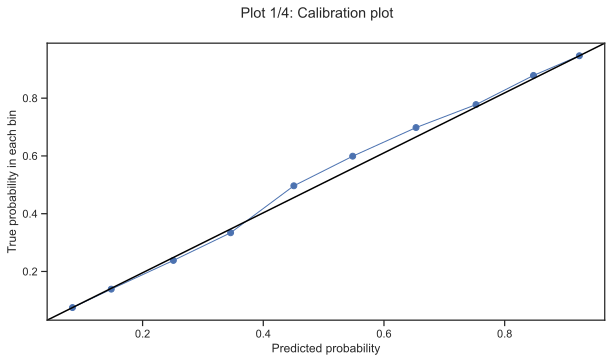

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


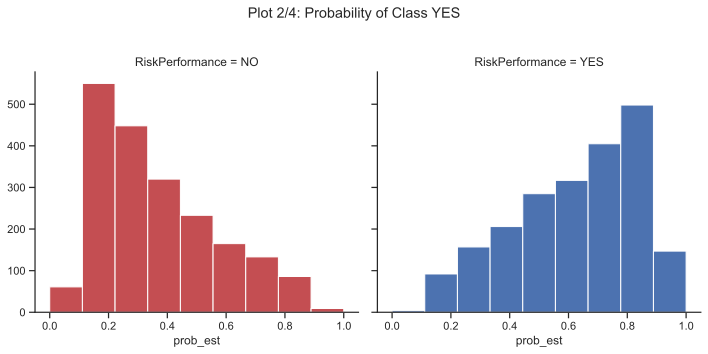

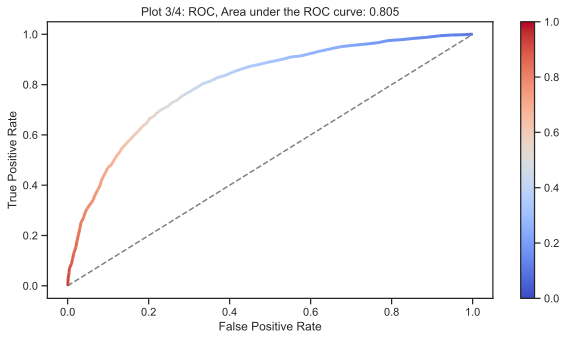

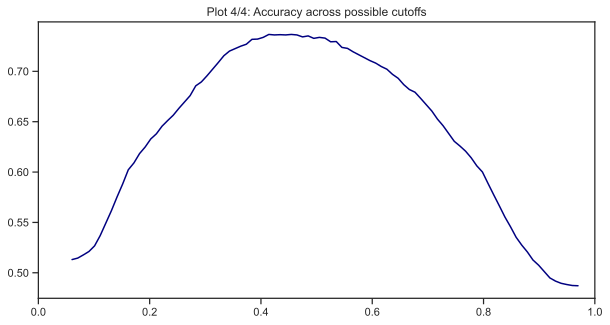

In [219]:
CT.plotClassPerformance(dfTR_KNN_eval['RiskPerformance'],knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass='YES')

Just like happened with the previous models, we obtain a quite calibrated model with about 0.799 AUC and 73% Accuracy, with balanced sensitivity and specificity.

At least, these are the values we obtain while training our model and testing it with CV, yet we still need to check how good does the model performs with our test dataset. However, as we trained our model and used CV, we expect the results not to differ too much.

In [220]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_knn_pred'], labels=['NO','YES'])

KeyError: 'Y_knn_pred'

We can see how the accuracy, sensitivity and specificitty go down a bit, yet it is just enough to make this KNN one of the worst models we have tried so far.

In order to try to improve these values we have 2 ideas.

1. In the previous model, given a new observation, we have given the same importance to all the 119 closest points to this observation, independently of their distance to the point. From now on, we will make the distance of every neighbour to our observation have an impact in the estimated probability for that observation to be YES or NO.
We do that through the parameter weights="distance" in the function that models KNN.

2. We mentioned earlier that it would be huge for our model to remove those variables without a big relation with Y, as those will add a lot of noise to the model. Based on their significativity on the logistic regressions model, we will decide to remove the least significant variables. 

#### 3.2:KNN with variable selection & weights distance

We are going to use the results of significance seen in the logistic regression model and remove those variables that were not significant.

About the categorical variable, some categories were significant and some were not, so we will just keep the numerical variable that represents those values in the model, in order to not loss any significant information.

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS2_KNN = INPUTS_KNN.copy()
variables_nused = ['MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades', 'lessthan1Month_num']

for variable in variables_nused:
    INPUTS2_KNN.remove(variable)
print(INPUTS2_KNN)

In [ ]:
X = df[INPUTS2_KNN]


# Split again including the numeric variable
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

## Configure mod 
# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier(weights="distance"))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit2 = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit2.fit(X_train[INPUTS2_KNN], y_train) 

print("kNN Trained")
 

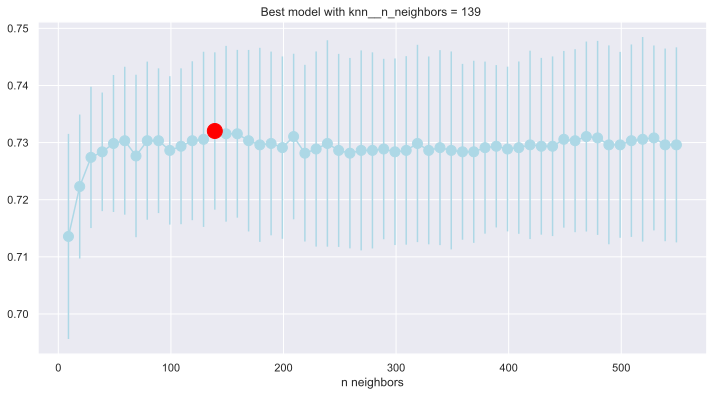

In [ ]:
MT.plotModelGridError(knn_fit2)




In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------


dfTR_KNN_eval['Y_knn2_pred'] = knn_fit2.predict(X_train[INPUTS2_KNN])
dfTR_KNN_eval['Y_knn2_prob_neg'] = knn_fit2.predict_proba(X_train[INPUTS2_KNN])[:,0]
dfTR_KNN_eval['Y_knn2_prob_pos'] = knn_fit2.predict_proba(X_train[INPUTS2_KNN])[:,1]
### Scale test using preprocess in training
dfTS_KNN_eval['Y_knn2_pred'] = knn_fit2.predict(X_test[INPUTS2_KNN])
dfTS_KNN_eval['Y_knn2_prob_neg'] = knn_fit2.predict_proba(X_test[INPUTS2_KNN])[:,0]
dfTS_KNN_eval['Y_knn2_prob_pos'] = knn_fit2.predict_proba(X_test[INPUTS2_KNN])[:,1]

### MODEL 4: DECISION TREES

After KNN, we are going to implement a slightly more complex model, a decision tree. 

For the decision trees we are going to develop, we are going to try and optimize the hyperparameter that represents the impurity a node needs to have to be allowed to split. A higher value of this parameter will turn out in smaller and more simple trees as nodes will tend to split less, so we will have less divisions, and exactly the opposite will happen for smaller values.

Besides that, we will control the size of the tree stablishing values such as the minimum number of observations in a terminal node, in order to avoid overfitting. We will start by using all the predictors in the data set, and we will use the categorical form of MSinceMostRecentInqexcl7days

In [221]:
INPUTS_DT_NUM = INPUTS_LR.copy()
INPUTS_DT_NUM.remove('MSinceMostRecentInqexcl7days')
INPUTS_DT_NUM.remove('lessthan1Month_num')
INPUTS_DT_CAT = ['MSinceMostRecentInqexcl7days']
INPUTS_DT = INPUTS_DT_NUM + INPUTS_DT_CAT

ValueError: list.remove(x): x not in list

In [ ]:
# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply different transformers to the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, INPUTS_DT_NUM),
        ('cat', categorical_transformer, INPUTS_DT_CAT)
    ])

# Define the parameter grid for Grid Search
param = {'DT__min_impurity_decrease': np.arange(0, 0.08, 0.001)}

# Create the Decision Tree pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply data preprocessing
    ('DT', DecisionTreeClassifier(criterion='gini',
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  random_state=0))
])

# Use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe,
                       param_grid=param,
                       n_jobs=-1,
                       scoring='accuracy',
                       cv=nFolds)
tree_fit.fit(X_train, y_train)  # Train the model

print("DT Trained")

DT Trained


Bigger values have been tried for the hyperparameter, using values from 0.1 to 0.25 but the results were absolutely inaccurate, so they won´t be shown.
We focus in smaller values with a maximum of 0.08.
 

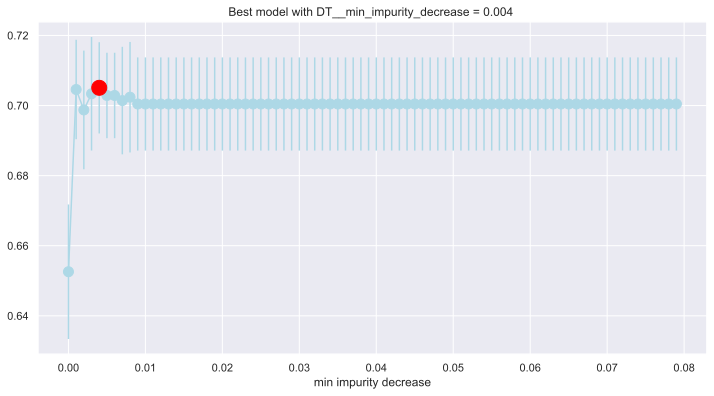

In [ ]:
MT.plotModelGridError(tree_fit)

We can see that in the best possible case for the minimum impurity decrease parameter, the training results are worse than the ones seen in the previous models. However, the important measure will be how the model behaves in the test samples, which we will check later. Prior to it, we show tho optimal tree obtained.  

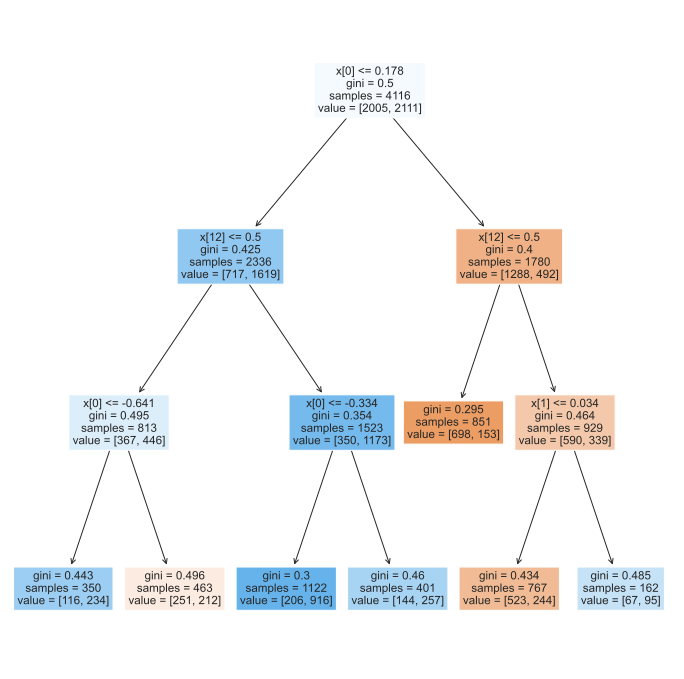

In [ ]:
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

The decision tree shows how the first two variables in X(ExternalRiskEstimate,NetFractionRevolvingBurden), along with one of the categories of MSinceMostRecentInqexcl7days, which is the category of LessThanOneMonth(we saw its significance in Logistic Regression) are the most important variables in the model. It also stands out that the tree seems a little too simple considering the amount of variables and observations, and the last plot shows how the amount of rows in the terminal nodes is at times, even bigger than a 1000, which translates into high levels of impurity in the nodes.

However, we tried smaller values for the minimum impurity decrease obtaining worst models, so it feels like increasing the complexity does not help in this case. Even though we may get no improvement, we will try afterwards to change some parameters in order to increase the complexity of the trees a little bit.



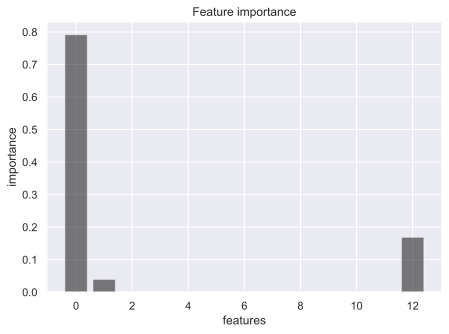

In [ ]:
index = np.arange(len(X_train[INPUTS_DT].columns)+3)

bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.tight_layout()
plt.show()

The graphic shows what we mentioned earlier about the 3 most important variables, being the 12th variable the category LessThanOneMonth. Now, we obtain the confusion matrix of our training for the optimal tree obtaines, and check how the tree predicts new observations with our test dataset.

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

[[0.54211663 0.45788337]
 [0.82021152 0.17978848]
 [0.54211663 0.45788337]
 ...
 [0.68187744 0.31812256]
 [0.18360071 0.81639929]
 [0.54211663 0.45788337]]


ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ... Y_LR_prob_pos Y_LR_sq_pred  \
7070                    1-6Months  ...      0.386701           NO   
4049              Greater12Months  ...      0.107536           NO   
3664                    1-6Months  ...      0.295551           NO   
3008                    1-6Months  ...      0.732391          YES   
6137                   Less1Month  ...      0.961611          YES   

      Y_LR_sq_prob_neg  Y_LR_sq_prob_pos Y_DT_pred  Y_DT_prob_neg  \
7070          0.515764          0.484236        NO       0.542117   
4049          0.839077          0.160923        NO       0.820212   
3664          0.624629          0.375371        NO       0.542117   
3008          0.183333          0.816667       YES       0.331429   
6137          0.040847          0.959153       YES       0.183601   

      Y_DT_prob_pos Y_DT2_pred  Y_DT2_prob_neg  Y_DT2_prob_pos  
7070       0.457883         NO        0.542117        0.457883  
4049       0.179788         NO        0.820212        0.179788  
3664       0.457883         NO        0.542117        0.457883  
3008       0.668571        YES        0.331429        0.668571  
6137       0.816399        YES        0.183601        0.816399  

[5 rows x 23 columns]

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_DT_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1472  533
      YES  609 1502

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.03
Sensitivity: 0.71
Specificity: 0.73
Precision: 0.71
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.36
Detection prevalence: 0.49
Balanced accuracy: 0.72
F1 Score: 0.72
Positive label: NO


In [ ]:
 CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_DT_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 346  155
      YES 158  370

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.39
Mcnemar's Test P-Value: 0.91
Sensitivity: 0.7
Specificity: 0.69
Precision: 0.69
Recall: 0.69
Prevalence: 0.51
Detection Rate: 0.36
Detection prevalence: 0.51
Balanced accuracy: 0.7
F1 Score: 0.69
Positive label: NO


This tree gives us a 70% of accuracy in the test observations, which is a lower value than the one btained in some of the previous models, so this tree turns out to be meaningless for us. As we mentioned earlier, we try to improve these results by increasing the complexity of the trees. 

In order to achieve this increase in the trees complexity, we are going to change the optimization criteria from Gini to Entropy. The Gini measure is defined in a way that it tries to minimize the probability of getting a classification wrong, unlike the entropy, with which the tree only tries that its nodes are as pure as possible, what means that it tries that each node only contains observations of one category, what tends to mean that the trees will be more complex.

We could see that the number of samples in each terminal node was much bigger than 5 in every case so we won´t touch the other 2 parameters as they are unlikely to have any effect in the model. The rest of parameters that can be considered in the decision tree implementation are defined by default in a way that they tend to make the model as complex as necessary. For example, there is a parameter with which you can control the maximum depth of the tree, and it is defined by default to None, what means that the tree can be as deep as wantes. Due to this, we do not define any other parameter of the DecisionTreecLassifier function. 


In [ ]:
param = {'DT__min_impurity_decrease': np.arange(0, 0.08, 0.001)}

# Create the Decision Tree pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply data preprocessing
    ('DT', DecisionTreeClassifier(criterion='entropy',
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  random_state=0))
])

# Use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit_en = GridSearchCV(estimator=pipe,
                       param_grid=param,
                       n_jobs=-1,
                       scoring='accuracy',
                       cv=nFolds)
tree_fit_en.fit(X_train, y_train)  # Train the model

print("DT Trained")

DT Trained


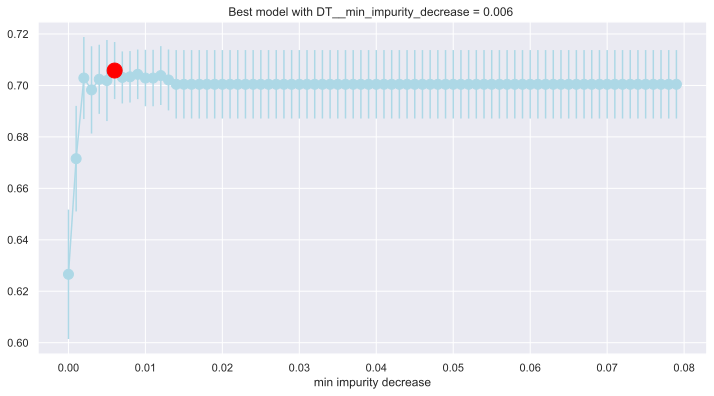

In [ ]:
MT.plotModelGridError(tree_fit_en)

We obtain a similar value for the accuracy and a bigger value for the minimum impurity decrease, so it feels like the model is compensating the increase of complexity we established by changing the optimization criteria with an equivalent increase of our complexity hyperparameter. 

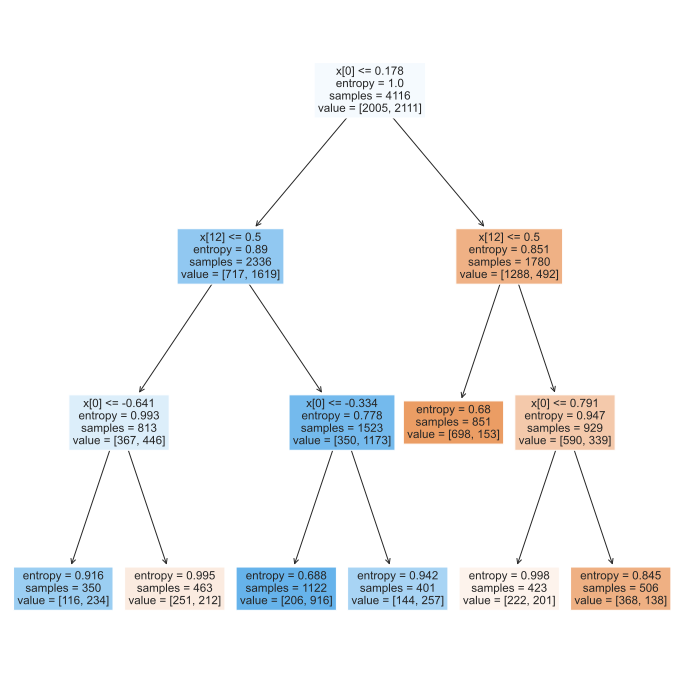

In [ ]:
plt.figure(figsize=(12, 12))
plot_tree(tree_fit_en.best_estimator_['DT'], filled=True)
plt.show()

As we mentioned earlier, we obtain an almost identical tree, in fact, we checked it and about 3100 of the observations are predicted the same probbailities with both models. So it feels like a more complex tree tends to return worse values somewhy, so the CV optimization discards it. Let´s check the confusion matrix this tree returns to see if it behaves better in the test dataset than our previous tree.

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT2_pred'] = tree_fit_en.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT2_prob_neg'] = tree_fit_en.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT2_prob_pos'] = tree_fit_en.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT2_pred'] = tree_fit_en.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT2_prob_neg'] = tree_fit_en.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT2_prob_pos'] = tree_fit_en.predict_proba(X_test[INPUTS_DT])[:,1]



#visualize evaluated data
dfTS_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
3501                    62                          75              70   
7125                    60                          13              59   
6575                    80                          23              62   
2983                    58                          55              18   
5181                    60                          40              23   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
3501                    155                    100                    57   
7125                    172                     86                    69   
6575                    116                     83                    23   
2983                     29                     90                    45   
5181                     49                     90                    31   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
3501                     21              23            4.027002e+12   
7125                      9              13            1.126085e+12   
6575                     24              26            3.522006e+13   
2983                     10              11            1.785671e+13   
5181                     16              16            3.522006e+13   

     MSinceMostRecentInqexcl7days  ... Y_LR_prob_pos Y_LR_sq_pred  \
3501                   Less1Month  ...      0.894754          YES   
7125                    1-6Months  ...      0.777924          YES   
6575                   Less1Month  ...      0.373687           NO   
2983                   Less1Month  ...      0.921365          YES   
5181                   Less1Month  ...      0.824471          YES   

      Y_LR_sq_prob_neg  Y_LR_sq_prob_pos Y_DT_pred  Y_DT_prob_neg  \
3501          0.138923          0.861077       YES       0.183601   
7125          0.136306          0.863694       YES       0.331429   
6575          0.710695          0.289305        NO       0.681877   
2983          0.102432          0.897568       YES       0.183601   
5181          0.232696          0.767304       YES       0.183601   

      Y_DT_prob_pos Y_DT2_pred  Y_DT2_prob_neg  Y_DT2_prob_pos  
3501       0.816399        YES        0.183601        0.816399  
7125       0.668571        YES        0.331429        0.668571  
6575       0.318123         NO        0.727273        0.272727  
2983       0.816399        YES        0.183601        0.816399  
5181       0.816399        YES        0.183601        0.816399  

[5 rows x 23 columns]

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_DT2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1539  466
      YES  704 1407

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.67
Specificity: 0.77
Precision: 0.69
Recall: 0.77
Prevalence: 0.51
Detection Rate: 0.34
Detection prevalence: 0.46
Balanced accuracy: 0.72
F1 Score: 0.72
Positive label: NO


In [ ]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_DT2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 368  133
      YES 178  350

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.4
Mcnemar's Test P-Value: 0.01
Sensitivity: 0.66
Specificity: 0.73
Precision: 0.67
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.34
Detection prevalence: 0.47
Balanced accuracy: 0.7
F1 Score: 0.7
Positive label: NO


The value for the accuracy is again 0.7, so we do not get any improvement at all, however, if we observe carefully, this tree has an interesting property. The value of the specificity is one of the highest obtained in all of the models we traines, what means that these model is good predicting those clients who are not going to leave the company.

It feels more logical to try and be accurate predicting those clients that are actually going to leave, but depending on what the company wants, this model could be useful.

### MODEL 5: RANDOM FOREST

We have struggled to increase the complexity of our decision tree by changing its parameters, what has meant that we did not get any improvement on the accuracy at all respect to the previous models trained.
 
This does not necessarily mean that decision trees are useless for our concrete case, as there are a bag of techniques that can be applied to them in order to get more complex, hence more accurate models. One of those techniques is random forest.

Random Forest is a technique that consists on the training of multiple trees that only consider a given number m among all the variables in the dataset, which are selected randomly for each tree trained. Let´s say that we establish m=5 and number_of_trees=50. Random Forest will train 50 models, choosing 5 varibles of our dataset randomly, and for each observation in the train dataset, each tree will give a prediction for yhe category of the response.

For each observation, it will be considered how many of the 50 predictions were a YES and how many were a NO, and the category that repeats the most will be our final prediction. Random Forest is a way more powerful model than a simple decision tree, however it implies that we need to take care of 3 parameters, those being the number m of variables considered, the number of trees to create and the minimal impurity decrease value.

In order to simplify the implementation of the model and reduce the dimensionality by one, we are going to define what we consider an appropiate value for m=6. This way, we only need to take care about the optimization of 2 parameters, and the difference of the model with values of m=3,4,5,7 would not be too significant.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Inputs of the model. Cambia según lo necesario para realizar la selección de variables.
INPUTS_RF = INPUTS_DT

# Definir los parámetros que deseas optimizar
param = {
    'RF__n_estimators': range(10, 200, 10),  # Número de árboles a crecer
    'RF__min_impurity_decrease': np.arange(0,0.05,0.005)  # Cambia estos valores según tus necesidades
}

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('RF', RandomForestClassifier(
        criterion='gini',  # Medida de impureza
        max_features=6,  # Número de variables muestreadas aleatoriamente en cada split
        min_samples_split=5,  # Número mínimo de observaciones en un nodo para cortar
        min_samples_leaf=5,  # Número mínimo de observaciones en un nodo terminal
        random_state=0  # Para replicación
    ))
])

# Utiliza Grid Search Cross Validation para encontrar los mejores parámetros para el modelo
nFolds = 10
rf_fit = GridSearchCV(
    estimator=pipe,  # Estructura del modelo a utilizar
    param_grid=param,  # Cuadrícula definida para la búsqueda
    n_jobs=-1,  # Número de núcleos a utilizar (paralelizar)
    scoring='accuracy',  # Métrica de evaluación
    cv=nFolds  # Número de divisiones (folds)
)

rf_fit.fit(X_train[INPUTS_RF], y_train)  # Búsqueda en la cuadrícula

print("Random Forest Trained")

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ExternalRiskEstimate',
                                                                          'NetFractionRevolvingBurden',
                                                                          'AverageMInFile',
                                                                          'MSinceOldestTradeOpen',
                                                                          'PercentTradesWBalance',
                                                                          'PercentInstallTrades',
                                                                          'NumSatisfactoryTrades',
                                                                          'NumTotalTrades',
                                                                          'PercentTradesNeverDel...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['MSinceMostRecentInqexcl7days'])])),
                                       ('RF',
                                        RandomForestClassifier(max_features=6,
                                                               min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'RF__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'RF__n_estimators': range(10, 200, 10)},
             scoring='accuracy')

In [ ]:
print("Mejores parámetros encontrados:")
print(rf_fit.best_params_)
print("Precisión con los mejores parámetros:")
print(rf_fit.best_score_)


Mejores parámetros encontrados:
{'RF__min_impurity_decrease': 0.0, 'RF__n_estimators': 80}
Precisión con los mejores parámetros:
0.7313000496066898


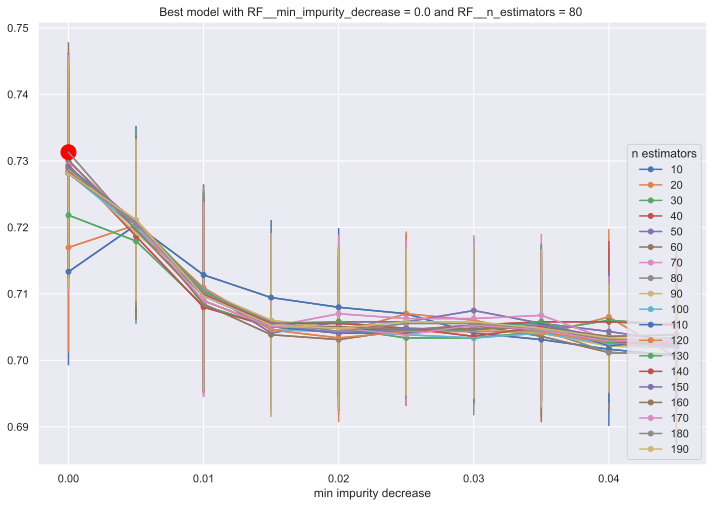

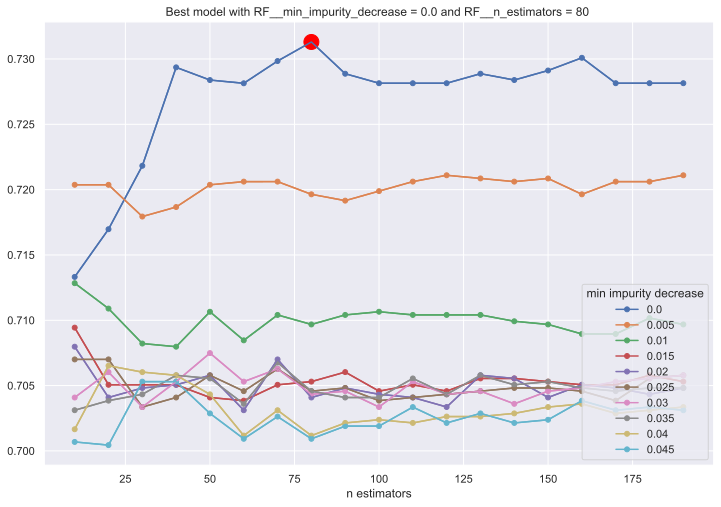

In [ ]:
MT.plotModelGridError(rf_fit)

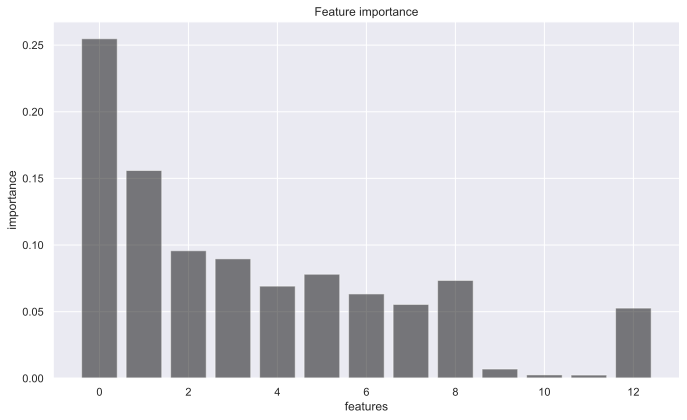

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_RF].columns)+3)
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.tight_layout()
plt.show()

The training accuracy obtained is slightly better than in the single decision tree model, and it improves to 73.1%.

The optimal parameters have been 80 trees ensembled and a value of 0 for the minimal impurity decrease for splitting, which means that there is no limit for the complexity of our trees.

In the graphics we can also see how every variable does have some importance, unlike in the decision tree model, what is explained by the property of random fores, of picking randomly the variables with which to create each tree. The variable 	ExternalRiskEstimate remains as the most important one and NetFractionRevolvingBurden as the second one, however, the variable that represents the category LessThanOneMonth, loses relevance compared to the previous model, and some variables that did not even appear in the decision tree model, seem to be quite significant for Random Forest.

Now, we are going to check if the random forest model also improves compared to the decision tree model in the test dataset.

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]

dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ... Y_LR_sq_prob_pos Y_DT_pred  \
7070                    1-6Months  ...         0.484236        NO   
4049              Greater12Months  ...         0.160923        NO   
3664                    1-6Months  ...         0.375371        NO   
3008                    1-6Months  ...         0.816667       YES   
6137                   Less1Month  ...         0.959153       YES   

      Y_DT_prob_neg  Y_DT_prob_pos Y_DT2_pred  Y_DT2_prob_neg  Y_DT2_prob_pos  \
7070       0.542117       0.457883         NO        0.542117        0.457883   
4049       0.820212       0.179788         NO        0.820212        0.179788   
3664       0.542117       0.457883         NO        0.542117        0.457883   
3008       0.331429       0.668571        YES        0.331429        0.668571   
6137       0.183601       0.816399        YES        0.183601        0.816399   

     Y_RF_pred  Y_RF_prob_neg  Y_RF_prob_pos  
7070       YES       0.287283       0.712717  
4049        NO       0.583650       0.416350  
3664        NO       0.766292       0.233708  
3008       YES       0.264802       0.735198  
6137       YES       0.037910       0.962090  

[5 rows x 26 columns]

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_RF_pred'], labels=['NO','YES'])

### PQ LA MATRIZ DE ANTES DA 0.89 ACCURACCY???

In [ ]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_RF_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 346  155
      YES 133  395

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.22
Sensitivity: 0.75
Specificity: 0.69
Precision: 0.72
Recall: 0.69
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.53
Balanced accuracy: 0.72
F1 Score: 0.71
Positive label: NO


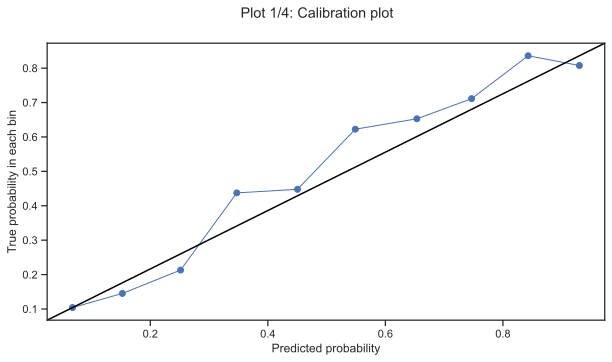

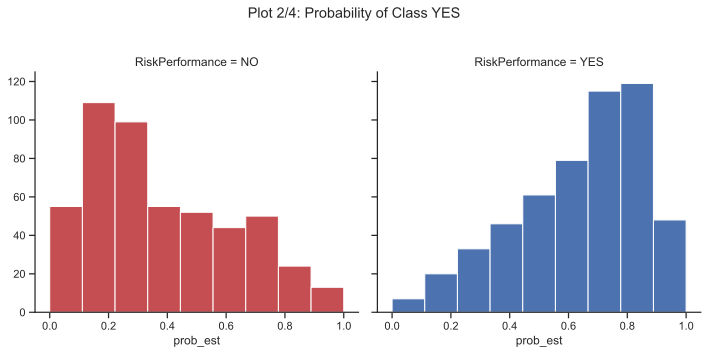

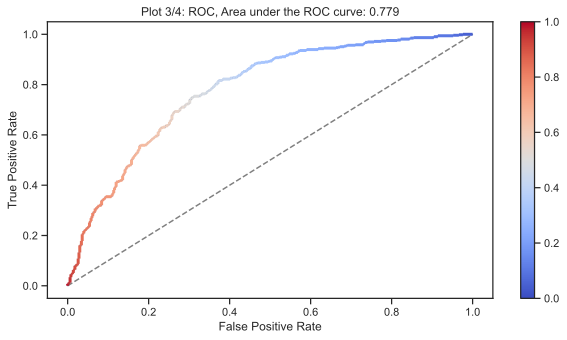

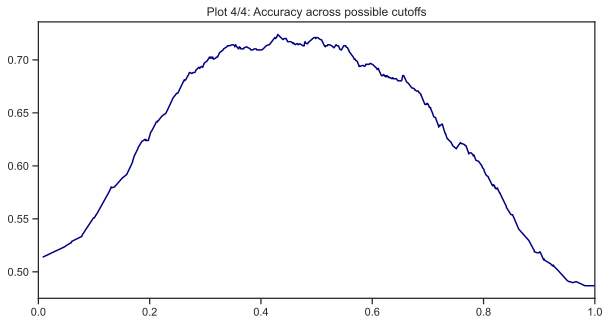

In [ ]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], rf_fit.predict_proba(X_test[INPUTS_RF]), selClass='YES')

We obtain a 72% of accuracy with a 75% of sensibility and a 69 % of specificity, what means that the model is better predicting the customers that will leave the company, an interesting property for our models. Graphics also show us that the model is slighty worse calibrated than some of the previous ones such as KNN or logistic regression, and its AUC is slightly worse with a value of 0.779.

### MODEL 6: SUPPORT VECTOR MACHINES (SVM)

The next model that we are going to implement will be Support Vector Machines. This classification algorithm performs well with only two classes, and using a kernel different from the linear on non-linear classification problems can be the key to find a correct model.

For that reason, we could use a grid to change between different cost terms (a lower cost term means that less errors are permitted: narrow margins that are rarely violated). Before showing the results, it seems that we need a higher C cost term in order to have a more biased classifier but with lower variance. It is important to indicate that we will use the selection of variables commented above, due to the fact that results are better and the interpretation is simpler.

In [77]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS_NUM_NOMS + INPUTS_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Cost term (We have proved that lower and higher cost terms are worse)
param = {'SVC__C': np.logspace(start=np.log10(0.001), stop=np.log10(0.1), num=5)} 

pipe = Pipeline(steps=[('Prep', preprocessor), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=0))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5 # With 10 folds the execution time collapses
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

print("Linear SVM Model Trained")

Linear SVM Model Trained


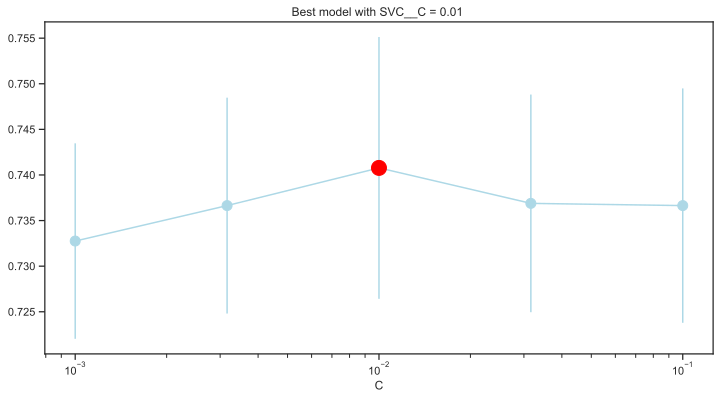

In [78]:
MT.plotModelGridError(Linear_SVC_fit.base_estimator, xscale="log")

In [79]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=5, scoring='accuracy').mean()

CV accuracy is


0.7385857447887789

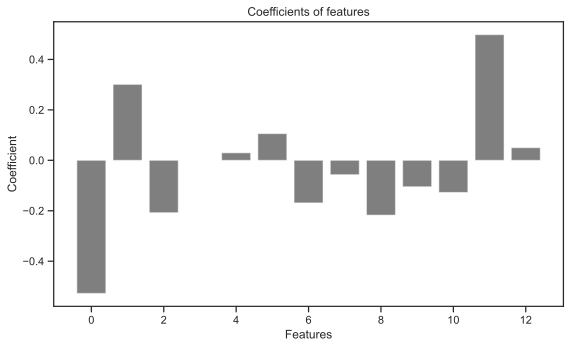

In [80]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(5 * 1.618, 5))
index = np.arange(len(X_train[INPUTS_LSVC].columns) + 3) #Add the dummies from the categorical variable
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.base_estimator.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.tight_layout()
plt.show()

The accuracy results are not much better than the previous models and the most important variables are similar to the rest, highlighting the first ones and some of the categories for `MSinceMostRecentInqexcl7days`.

In [81]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train[INPUTS_LSVC])
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test[INPUTS_LSVC])
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ...  Y_LR_prob_pos  Y_LR_sq_pred  \
7070                    1-6Months  ...       0.387416            NO   
4049              Greater12Months  ...       0.098935            NO   
3664                    1-6Months  ...       0.295913            NO   
3008                    1-6Months  ...       0.732729           YES   
6137                   Less1Month  ...       0.961446           YES   

     Y_LR_sq_prob_neg Y_LR_sq_prob_pos  Y_LR_2_pred  Y_LR_2_prob_neg  \
7070         0.646502         0.353498           NO         0.623078   
4049         0.893246         0.106754           NO         0.884494   
3664         0.731594         0.268406           NO         0.715017   
3008         0.288566         0.711434          YES         0.275160   
6137         0.033975         0.966025          YES         0.038700   

     Y_LR_2_prob_pos  Y_LSVC_pred  Y_LSVC_prob_neg Y_LSVC_prob_pos  
7070        0.376922           NO         0.589647        0.410353  
4049        0.115506           NO         0.873345        0.126655  
3664        0.284983           NO         0.703137        0.296863  
3008        0.724840          YES         0.215511        0.784489  
6137        0.961300          YES         0.031935        0.968065  

[5 rows x 25 columns]

In [300]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LSVC_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1461  544
      YES  516 1595

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.41
Sensitivity: 0.76
Specificity: 0.73
Precision: 0.74
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [301]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LSVC_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 343  158
      YES 123  405

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.04
Sensitivity: 0.77
Specificity: 0.68
Precision: 0.74
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.73
F1 Score: 0.71
Positive label: NO


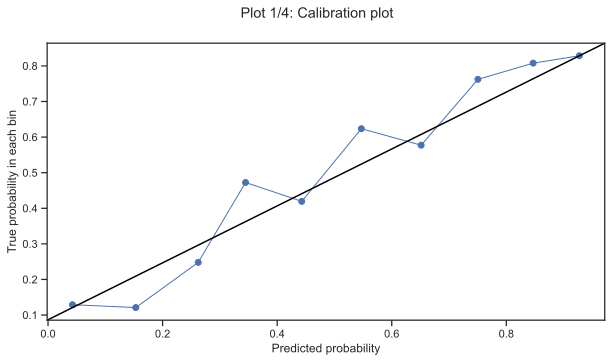

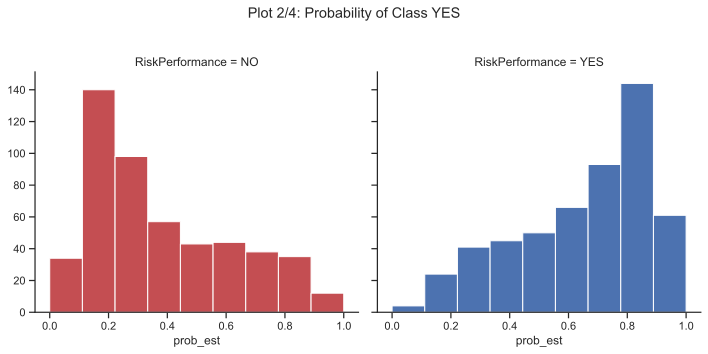

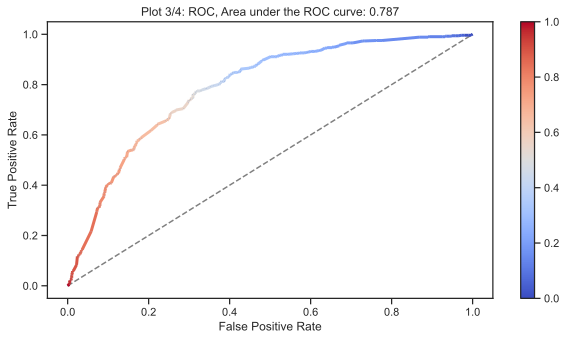

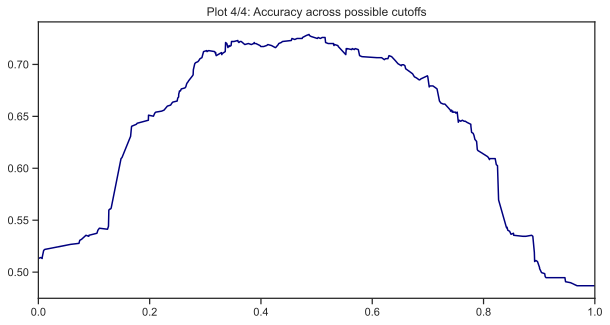

In [82]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC]), selClass='YES')

The results obtained indicate that, due to the rate between the computation power needed and the resulting model, there are better, easier and faster methods to classify the response variable. Nevertheless, maybe a more complex and non-linear kernel will help in our duty, bearing in mind that it will be harder to control the overfitting.

Therefore, we develop the same model with a radial kernel instead, searching for better accuracy. In this case, we will need a higher C value searching for less overfitted models (accepting more errors) and an intermediate gamma value.

In [303]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RSVC = INPUTS_NUM_NOMS + INPUTS_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Cost term and gamma (We have proved that the optimal is located in a high C value: near 1 and a gamma around (0.01, 0.1))
param = {'SVC__C': [0.01,0.1, 1, 2, 5], # Cost term
         'SVC__gamma':[0.001,0.01,0.1, 1, 2]} # Inverse width parameter in the Gaussian Radial Basis kernel 

pipe = Pipeline(steps=[('Prep', preprocessor), 
                        ('SVC',  SVC(kernel='rbf', # radial kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=0))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5 # With 10 folds the execution time collapses
Radial_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Radial_SVC_gcv.fit(X_train[INPUTS_RSVC], y_train) # Search in grid

print("Radial SVM Model Trained")

Radial SVM Model Trained


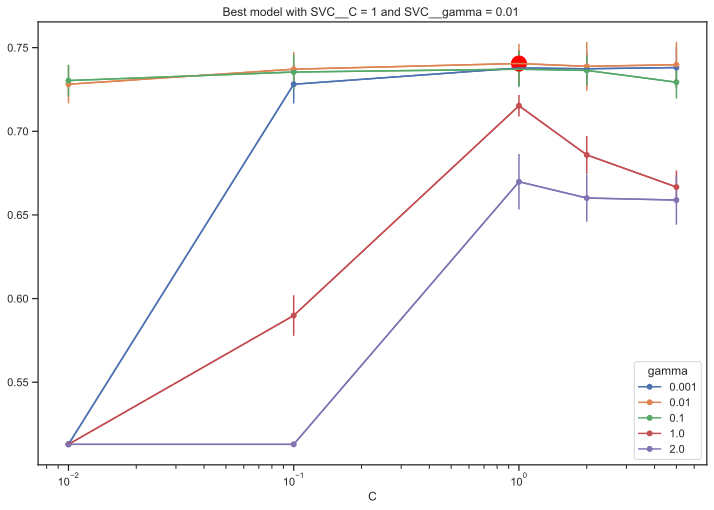

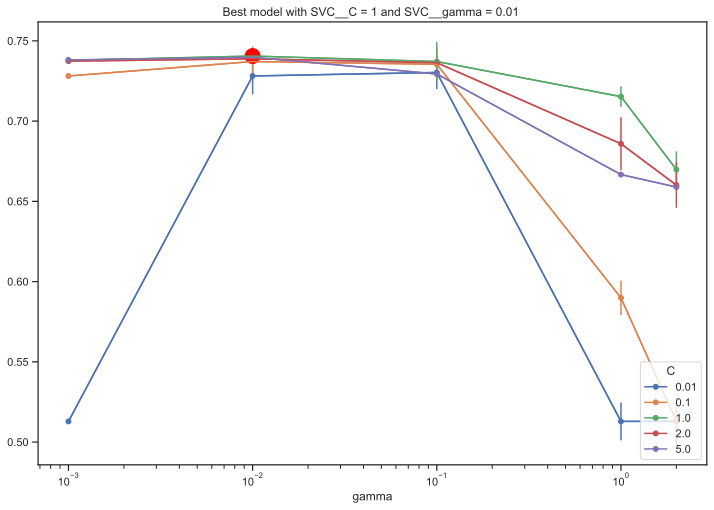

In [304]:
MT.plotModelGridError(Radial_SVC_gcv, xscale="log", xscale2='log')

In [305]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_SVC_pred'] = Radial_SVC_gcv.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = Radial_SVC_gcv.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = Radial_SVC_gcv.predict_proba(X_train[INPUTS_RSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = Radial_SVC_gcv.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = Radial_SVC_gcv.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = Radial_SVC_gcv.predict_proba(X_test[INPUTS_RSVC])[:,1]

dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  ...  Y_LDA_prob_pos  Y_QDA_pred  \
7070                    1-6Months  ...        0.355615          NO   
4049              Greater12Months  ...        0.073472          NO   
3664                    1-6Months  ...        0.303191          NO   
3008                    1-6Months  ...        0.708434         YES   
6137                   Less1Month  ...        0.958341         YES   

     Y_QDA_prob_neg Y_QDA_prob_pos  Y_LSVC_pred  Y_LSVC_prob_neg  \
7070       0.510157       0.489843           NO         0.589647   
4049       0.900102       0.099898           NO         0.873345   
3664       0.668414       0.331586           NO         0.703137   
3008       0.361395       0.638605          YES         0.215511   
6137       0.021048       0.978952          YES         0.031935   

     Y_LSVC_prob_pos  Y_SVC_pred  Y_SVC_prob_neg Y_SVC_prob_pos  
7070        0.410353          NO        0.547971       0.452029  
4049        0.126655          NO        0.885524       0.114476  
3664        0.296863          NO        0.703557       0.296443  
3008        0.784489         YES        0.209739       0.790261  
6137        0.968065         YES        0.070190       0.929810  

[5 rows x 31 columns]

In [306]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_SVC_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1450  555
      YES  502 1609

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.49
Mcnemar's Test P-Value: 0.11
Sensitivity: 0.76
Specificity: 0.72
Precision: 0.74
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.53
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [307]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_SVC_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 343  158
      YES 122  406

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.04
Sensitivity: 0.77
Specificity: 0.68
Precision: 0.74
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.73
F1 Score: 0.71
Positive label: NO


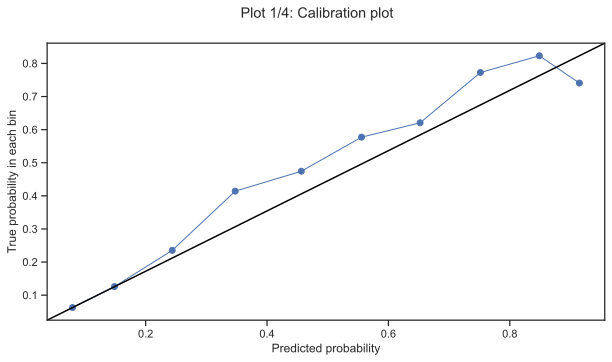

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


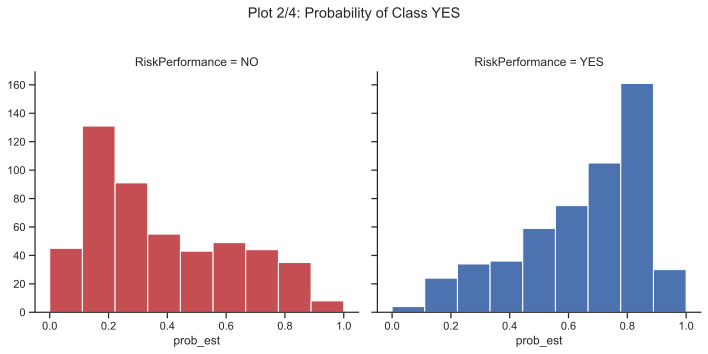

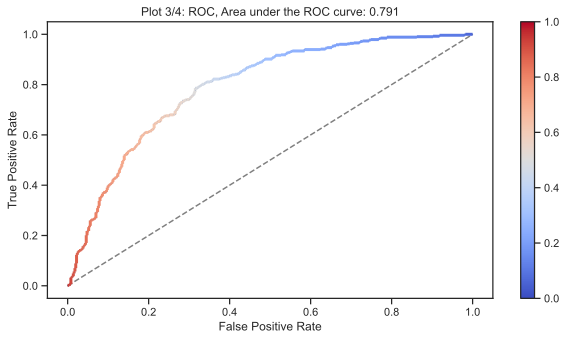

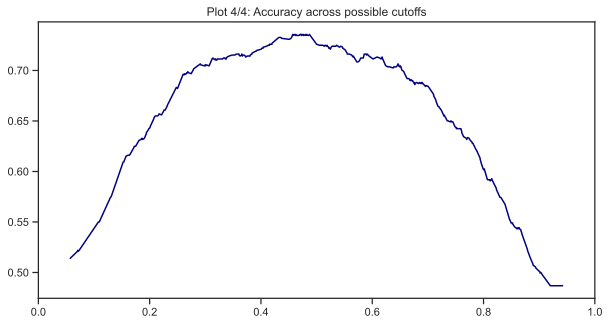

In [308]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], Radial_SVC_gcv.predict_proba(X_test), selClass='YES')

The presented plots and confusion matrices indicate that the prediction is worse than expected, being slightly better than the linear kernel with a lot higher level of computer power demand and execution time. We could observe that neither the first or the second model have serious issues with overfitting, suggesting that maybe it is the best accuracy we could get for the exercise.

### Multi-Layer Perceptron (MLP)

The next model that we are going to implement will be a Multilayer Perceptron (MLP) neural network. This neural network architecture is versatile and can handle both binary and multi-class classification problems. By configuring the network with non-linear activation functions and appropriate architecture, it can effectively address non-linear classification tasks.

In [86]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP = INPUTS_NUM_NOD

#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------

param = {'MLP__alpha': [1e-3, 5, 8], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,), (5,1), (5,3)]} # Number of neurons in each hidden layer, enters as tuples
#param = {'MLP__alpha': [0], # L2 regularization term 
#         'MLP__hidden_layer_sizes':[(20,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function adam para cuando pete 
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=150,
                                             verbose = True))]) # For replication
 
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

print("MLP Trained")

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29270D-01    |proj g|=  1.30980D-01

At iterate    1    f=  6.81458D-01    |proj g|=  4.15504D-02

At iterate    2    f=  6.25243D-01    |proj g|=  4.44842D-02

At iterate    3    f=  5.63826D-01    |proj g|=  2.82755D-02

At iterate    4    f=  5.45673D-01    |proj g|=  4.99404D-03

At iterate    5    f=  5.43949D-01    |proj g|=  4.73101D-03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29749D-01    |proj g|=  1.31241D-01

At iterate    6    f=  5.42283D-01    |proj g|=  6.30348D-03

At iterate    7    f=  5.40745D-01    |proj g|=  5.57541D-03

At iterate    1    f=  6.81475D-01    |proj g|=  4.19332D-02

At iterate    8    f=  5.38706D-01    |proj g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate  287    f=  5.17763D-01    |proj g|=  4.41227D-04

At iterate  277    f=  5.16428D-01    |proj g|=  7.21163D-04

At iterate    6    f=  5.44613D-01    |proj g|=  6.13185D-03

At iterate  288    f=  5.17759D-01    |proj g|=  4.59562D-04

At iterate    7    f=  5.43016D-01    |proj g|=  5.21708D-03

At iterate  278    f=  5.16395D-01    |proj g|=  6.29521D-04

At iterate    8    f=  5.40881D-01    |proj g|=  4.56710D-03

At iterate  289    f=  5.17741D-01    |proj g|=  4.24436D-04

At iterate  279    f=  5.16382D-01    |proj g|=  1.10438D-03


At iterate    9    f=  5.39271D-01    |proj g|=  3.66722D-03
At iterate  290    f=  5.17732D-01    |proj g|=  1.88763D-03

At iterate  280    f=  5.16336D-01    |proj g|=  3.65819D-04

At iterate   10    f=  5.38368D-01    |proj g|=  1.73812D-03

At iterate  291    f=  5.17704D-01    |proj g|=  8.41104D-04

At iterate  281    f=  5.16321D-01    |proj g|=  1.70330D-04

At iterate   11    f=  5.37979D-01    |proj g|=  1.50329D-03

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  5.27554D-01    |proj g|=  3.85471D-04
At iterate  158    f=  5.21876D-01    |proj g|=  5.64861D-04

At iterate  221    f=  5.20440D-01    |proj g|=  2.44474D-04


At iterate  215    f=  5.20399D-01    |proj g|=  1.68787D-03
At iterate   51    f=  5.27423D-01    |proj g|=  1.38817D-03

At iterate  159    f=  5.21822D-01    |proj g|=  8.29416D-04

At iterate  222    f=  5.20431D-01    |proj g|=  3.55248D-04


At iterate   52    f=  5.27295D-01    |proj g|=  1.10622D-03
At iterate  216    f=  5.20390D-01    |proj g|=  1.26798D-03

At iterate  160    f=  5.21815D-01    |proj g|=  2.23139D-03

At iterate  223    f=  5.20423D-01    |proj g|=  2.15663D-04


At iterate   53    f=  5.27191D-01    |proj g|=  1.24227D-03
At iterate  217    f=  5.20379D-01    |proj g|=  9.65053D-04

At iterate  161    f=  5.21744D-01    |proj g|=  8.00430D-04

At iterate  224    f=  5.20418D-01    |proj g|=  2.72502D-04

At iterate  218    f=  5.20376D-01    |proj g|=  1.32508D-03

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is uncon

At iterate  308    f=  5.19254D-01    |proj g|=  1.65382D-03

At iterate  255    f=  5.20389D-01    |proj g|=  3.00558D-04

At iterate   17    f=  5.37440D-01    |proj g|=  2.41174D-03

At iterate  309    f=  5.19248D-01    |proj g|=  8.20372D-04

At iterate  142    f=  5.22690D-01    |proj g|=  8.16487D-04

At iterate  256    f=  5.20385D-01    |proj g|=  6.20507D-04

At iterate   18    f=  5.36802D-01    |proj g|=  1.98865D-03

At iterate  310    f=  5.19247D-01    |proj g|=  8.41527D-04

At iterate  257    f=  5.20379D-01    |proj g|=  7.71307D-04

At iterate  311    f=  5.19243D-01    |proj g|=  1.19960D-03

At iterate   19    f=  5.36499D-01    |proj g|=  1.74422D-03

At iterate  258    f=  5.20375D-01    |proj g|=  1.55468D-03

At iterate  312    f=  5.19237D-01    |proj g|=  1.32925D-03

At iterate   20    f=  5.36320D-01    |proj g|=  1.39509D-03

At iterate  259    f=  5.20364D-01    |proj g|=  4.45431D-04

At iterate   21    f=  5.36119D-01    |proj g|=  1.10199D-03

At itera

 This problem is unconstrained.


At iterate  161    f=  5.23688D-01    |proj g|=  3.67057D-04
At iterate  118    f=  5.24309D-01    |proj g|=  9.49257D-04

At iterate   20    f=  5.49803D-01    |proj g|=  6.55268D-03

At iterate  162    f=  5.23651D-01    |proj g|=  1.31931D-03

At iterate   21    f=  5.48927D-01    |proj g|=  2.10526D-03

At iterate  163    f=  5.23605D-01    |proj g|=  1.73961D-03

At iterate  119    f=  5.24293D-01    |proj g|=  7.15234D-04

At iterate   86    f=  5.29371D-01    |proj g|=  3.38708D-03


At iterate   22    f=  5.47933D-01    |proj g|=  3.58138D-03
At iterate  164    f=  5.23519D-01    |proj g|=  1.92895D-03

At iterate  120    f=  5.24268D-01    |proj g|=  6.27298D-04

At iterate   87    f=  5.29329D-01    |proj g|=  1.88163D-03

At iterate   23    f=  5.47096D-01    |proj g|=  4.57549D-03

At iterate  121    f=  5.24220D-01    |proj g|=  7.06538D-04


At iterate   88    f=  5.29303D-01    |proj g|=  1.02204D-03
At iterate  165    f=  5.23465D-01    |proj g|=  2.25171D-03

At iterat

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


342D-03

At iterate  106    f=  5.30814D-01    |proj g|=  2.77323D-03

At iterate    8    f=  5.66527D-01    |proj g|=  6.33290D-03

At iterate  207    f=  5.19401D-01    |proj g|=  1.06098D-03

At iterate  176    f=  5.27662D-01    |proj g|=  1.82007D-03

At iterate    9    f=  5.63064D-01    |proj g|=  1.64826D-02

At iterate  107    f=  5.30770D-01    |proj g|=  1.94717D-03

At iterate  208    f=  5.19380D-01    |proj g|=  1.00528D-03

At iterate  177    f=  5.27648D-01    |proj g|=  1.35351D-03

At iterate  108    f=  5.30706D-01    |proj g|=  3.95715D-03

At iterate  209    f=  5.19357D-01    |proj g|=  1.93532D-03

At iterate  178    f=  5.27631D-01    |proj g|=  3.14932D-03

At iterate   10    f=  5.61762D-01    |proj g|=  1.21813D-02

At iterate  109    f=  5.30647D-01    |proj g|=  4.86903D-03

At iterate  179    f=  5.27611D-01    |proj g|=  2.36762D-03

At iterate   11    f=  5.60334D-01    |proj g|=  3.53077D-03

At iterate  110    f=  5.30627D-01    |proj g|=  8.92741D-03


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


erate  303    f=  5.18320D-01    |proj g|=  5.88169D-04

At iterate  279    f=  5.26120D-01    |proj g|=  3.20306D-03

At iterate  212    f=  5.28503D-01    |proj g|=  1.64935D-03

At iterate  304    f=  5.18317D-01    |proj g|=  8.92742D-04

At iterate  213    f=  5.28496D-01    |proj g|=  1.86365D-03

At iterate  280    f=  5.26100D-01    |proj g|=  2.07730D-03

At iterate  106    f=  5.23223D-01    |proj g|=  1.73855D-03

At iterate  305    f=  5.18313D-01    |proj g|=  4.64345D-04

At iterate  107    f=  5.23113D-01    |proj g|=  1.70330D-03

At iterate  281    f=  5.26078D-01    |proj g|=  2.29339D-03

At iterate  306    f=  5.18307D-01    |proj g|=  5.58507D-04

At iterate  214    f=  5.28489D-01    |proj g|=  1.21417D-03

At iterate  108    f=  5.23013D-01    |proj g|=  1.80501D-03

At iterate  282    f=  5.26058D-01    |proj g|=  3.88919D-03

At iterate  215    f=  5.28472D-01    |proj g|=  9.87030D-04


At iterate  283    f=  5.26046D-01    |proj g|=  2.91713D-03
At iterate  1

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


At iterate  317    f=  5.25983D-01    |proj g|=  1.84590D-03

At iterate  392    f=  5.20940D-01    |proj g|=  3.33038D-04

At iterate  327    f=  5.21756D-01    |proj g|=  4.88182D-04

At iterate  398    f=  5.22833D-01    |proj g|=  3.28830D-04

At iterate  393    f=  5.20935D-01    |proj g|=  3.87211D-04

At iterate  328    f=  5.21750D-01    |proj g|=  3.65062D-04

At iterate  399    f=  5.22832D-01    |proj g|=  2.45910D-04

At iterate  318    f=  5.25972D-01    |proj g|=  1.96760D-03

At iterate  394    f=  5.20932D-01    |proj g|=  6.63258D-04

At iterate  329    f=  5.21744D-01    |proj g|=  6.29655D-04

At iterate  400    f=  5.22831D-01    |proj g|=  2.63663D-04

At iterate  319    f=  5.25959D-01    |proj g|=  1.63405D-03

At iterate  395    f=  5.20928D-01    |proj g|=  2.01634D-04

At iterate  330    f=  5.21740D-01    |proj g|=  1.95944D-03

At iterate  401    f=  5.22829D-01    |proj g|=  3.56257D-04

At iterate  320    f=  5.25936D-01    |proj g|=  9.69007D-04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  409    f=  5.24757D-01    |proj g|=  8.16725D-04
At iterate  423    f=  5.20910D-01    |proj g|=  1.28877D-03

At iterate   23    f=  5.44023D-01    |proj g|=  6.20839D-03

At iterate  410    f=  5.24751D-01    |proj g|=  1.12569D-03

At iterate   17    f=  5.52148D-01    |proj g|=  5.01158D-03

At iterate  411    f=  5.24744D-01    |proj g|=  1.03580D-03

At iterate  412    f=  5.24739D-01    |proj g|=  1.51002D-03

At iterate  424    f=  5.20901D-01    |proj g|=  2.95867D-03

At iterate   18    f=  5.50921D-01    |proj g|=  5.44632D-03

At iterate  413    f=  5.24734D-01    |proj g|=  4.47352D-04

At iterate  425    f=  5.20886D-01    |proj g|=  1.04615D-03

At iterate   19    f=  5.49076D-01    |proj g|=  2.49690D-03

At iterate  414    f=  5.24731D-01    |proj g|=  7.73158D-04

At iterate  426    f=  5.20878D-01    |proj g|=  6.78635D-04

At iterate   20    f=  5.48294D-01    |proj g|=  1.13249D-02

At iterate   24    f=  5.43148D-01    |proj g|=  3.39509D-03

At iterat

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   84    f=  5.33241D-01    |proj g|=  1.71078D-03

At iterate   75    f=  5.34505D-01    |proj g|=  1.65824D-03

At iterate   85    f=  5.33157D-01    |proj g|=  9.79021D-04

At iterate   76    f=  5.34395D-01    |proj g|=  1.29751D-03

At iterate   11    f=  5.48701D-01    |proj g|=  1.16504D-02


At iterate   77    f=  5.34294D-01    |proj g|=  1.58543D-03
At iterate   86    f=  5.33095D-01    |proj g|=  4.00470D-03

At iterate   87    f=  5.33071D-01    |proj g|=  5.31675D-03

At iterate   12    f=  5.45161D-01    |proj g|=  2.85603D-03

At iterate   78    f=  5.34221D-01    |proj g|=  3.13314D-03

At iterate   88    f=  5.33020D-01    |proj g|=  6.37907D-04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           77     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94927D-01    |proj g|=  3.52343D-02

At iterate   13    f=  5.43914D-01    |proj g|=  2.42473D-03

At iterate   79    f=  5.34

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate   97    f=  5.24730D-01    |proj g|=  6.53222D-04

At iterate  116    f=  5.21715D-01    |proj g|=  5.93850D-04

At iterate  197    f=  5.30816D-01    |proj g|=  1.33722D-03

At iterate   98    f=  5.24679D-01    |proj g|=  1.09055D-03

At iterate  208    f=  5.27335D-01    |proj g|=  1.45668D-03

At iterate  198    f=  5.30799D-01    |proj g|=  2.08904D-03

At iterate  209    f=  5.27312D-01    |proj g|=  8.35680D-04

At iterate  199    f=  5.30779D-01    |proj g|=  6.20955D-03

At iterate  117    f=  5.21703D-01    |proj g|=  1.28654D-03

At iterate  210    f=  5.27281D-01    |proj g|=  4.81322D-04

At iterate   99    f=  5.24657D-01    |proj g|=  9.78120D-04

At iterate  211    f=  5.27252D-01    |proj g|=  1.59116D-03

At iterate  118    f=  5.21681D-01    |proj g|=  7.69053D-04

At iterate  200    f=  5.30749D-01    |proj g|=  3.08460D-03

At iterate  100    f=  5.24621D-01    |proj g|=  6.99377D-04

At iterate  212    f=  5.27225D-01    |proj g|=  1.27448D-03

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


774D-01    |proj g|=  1.56578D-03

At iterate  332    f=  5.13845D-01    |proj g|=  1.45686D-03

At iterate  345    f=  5.11637D-01    |proj g|=  9.70376D-04

At iterate   20    f=  5.41006D-01    |proj g|=  1.22199D-02

At iterate   21    f=  5.40344D-01    |proj g|=  3.63213D-03

At iterate    1    f=  6.91664D-01    |proj g|=  6.28059D-03

At iterate   22    f=  5.40087D-01    |proj g|=  1.67452D-03

At iterate   23    f=  5.39733D-01    |proj g|=  1.52799D-03

At iterate  333    f=  5.13805D-01    |proj g|=  2.06015D-03

At iterate  346    f=  5.11543D-01    |proj g|=  4.74356D-03

At iterate  347    f=  5.11493D-01    |proj g|=  1.75544D-03

At iterate    2    f=  6.79166D-01    |proj g|=  2.78768D-02

At iterate    3    f=  6.62185D-01    |proj g|=  7.80793D-02

At iterate   24    f=  5.39103D-01    |proj g|=  3.07102D-03

At iterate  348    f=  5.11459D-01    |proj g|=  1.21729D-03

At iterate   25    f=  5.38488D-01    |proj g|=  2.05466D-03

At iterate  334    f=  5.13790D-01 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  156    f=  5.19746D-01    |proj g|=  7.69922D-04

At iterate  144    f=  5.20340D-01    |proj g|=  9.11267D-04

At iterate  304    f=  5.10374D-01    |proj g|=  7.54445D-04

At iterate  276    f=  5.11934D-01    |proj g|=  5.45974D-04

At iterate  145    f=  5.20309D-01    |proj g|=  7.28567D-04

At iterate  277    f=  5.11906D-01    |proj g|=  1.46170D-03

At iterate  157    f=  5.19687D-01    |proj g|=  5.60226D-04

At iterate  305    f=  5.10347D-01    |proj g|=  3.35273D-04

At iterate  278    f=  5.11883D-01    |proj g|=  5.24129D-04

At iterate  306    f=  5.10325D-01    |proj g|=  4.83195D-04

At iterate  158    f=  5.19630D-01    |proj g|=  1.62081D-03

At iterate  159    f=  5.19541D-01    |proj g|=  1.47109D-03

At iterate  307    f=  5.10303D-01    |proj g|=  1.40808D-03

At iterate  308    f=  5.10261D-01    |proj g|=  5.89149D-04

At iterate  279    f=  5.11865D-01    |proj g|=  6.88692D-04

At iterate  160    f=  5.19517D-01    |proj g|=  2.42074D-03

At iter

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   89    f=  5.25933D-01    |proj g|=  7.39464D-04

At iterate   13    f=  5.49723D-01    |proj g|=  4.21046D-03
At iterate  429    f=  5.12151D-01    |proj g|=  8.32732D-04

At iterate   14    f=  5.48653D-01    |proj g|=  1.97047D-03

At iterate   90    f=  5.25805D-01    |proj g|=  7.35101D-04

At iterate   15    f=  5.47946D-01    |proj g|=  2.24651D-03

At iterate   91    f=  5.25622D-01    |proj g|=  2.75255D-03

At iterate   16    f=  5.46981D-01    |proj g|=  5.69208D-03

At iterate  430    f=  5.12146D-01    |proj g|=  2.60127D-04

At iterate  113    f=  5.24246D-01    |proj g|=  1.70268D-03

At iterate  114    f=  5.24222D-01    |proj g|=  7.21283D-04

At iterate  431    f=  5.12143D-01    |proj g|=  3.24506D-04

At iterate   92    f=  5.25526D-01    |proj g|=  3.57205D-03

At iterate  432    f=  5.12140D-01    |proj g|=  4.85205D-04

At iterate   93    f=  5.25452D-01    |proj g|=  1.27944D-03

At iterate  115    f=  5.24209D-01    |proj g|=  6.64197D-04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   24    f=  5.37830D-01    |proj g|=  3.22436D-03

At iterate  440    f=  5.12093D-01    |proj g|=  2.72520D-04

At iterate  441    f=  5.12088D-01    |proj g|=  1.04887D-03

At iterate   25    f=  5.37651D-01    |proj g|=  8.24136D-03

At iterate  442    f=  5.12077D-01    |proj g|=  2.56504D-04

At iterate  121    f=  5.24112D-01    |proj g|=  5.87842D-04

At iterate  443    f=  5.12072D-01    |proj g|=  4.67882D-04

At iterate  102    f=  5.24475D-01    |proj g|=  1.38242D-03

At iterate  122    f=  5.24105D-01    |proj g|=  5.69954D-04

At iterate   26    f=  5.36635D-01    |proj g|=  2.68252D-03

At iterate  103    f=  5.24404D-01    |proj g|=  4.11501D-03

At iterate   27    f=  5.36524D-01    |proj g|=  2.32501D-03

At iterate  104    f=  5.24289D-01    |proj g|=  1.52857D-03

At iterate  444    f=  5.12065D-01    |proj g|=  5.32574D-04

At iterate  123    f=  5.24092D-01    |proj g|=  4.53814D-04

At iterate   28    f=  5.36391D-01    |proj g|=  9.49325D-04

At iter

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1    |proj g|=  1.17350D-03

At iterate  197    f=  5.23967D-01    |proj g|=  1.04397D-03

At iterate  300    f=  5.16300D-01    |proj g|=  1.98112D-03

At iterate  270    f=  5.16523D-01    |proj g|=  1.56170D-03

At iterate  151    f=  5.25115D-01    |proj g|=  1.07149D-03

At iterate  301    f=  5.16290D-01    |proj g|=  3.99410D-03

At iterate  152    f=  5.25093D-01    |proj g|=  1.07899D-03

At iterate  302    f=  5.16276D-01    |proj g|=  1.30845D-03

At iterate  198    f=  5.23935D-01    |proj g|=  2.19107D-03

At iterate  153    f=  5.25037D-01    |proj g|=  1.86931D-03

At iterate  303    f=  5.16269D-01    |proj g|=  1.87423D-03

At iterate  271    f=  5.16488D-01    |proj g|=  2.60126D-03

At iterate  199    f=  5.23861D-01    |proj g|=  8.35589D-04

At iterate  304    f=  5.16260D-01    |proj g|=  1.64700D-03

At iterate  154    f=  5.25009D-01    |proj g|=  5.48579D-03

At iterate  272    f=  5.16449D-01    |proj g|=  3.04089D-03

At iterate  200    f=  5.23810D-01    |pr

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is uncon

39824D-04

At iterate  195    f=  5.23689D-01    |proj g|=  1.01398D-03

At iterate  341    f=  5.15770D-01    |proj g|=  2.02918D-03

At iterate  308    f=  5.15440D-01    |proj g|=  9.51065D-04


At iterate  235    f=  5.22306D-01    |proj g|=  7.87958D-04
At iterate  342    f=  5.15747D-01    |proj g|=  2.47691D-03

At iterate  196    f=  5.23678D-01    |proj g|=  1.25323D-03

At iterate  236    f=  5.22291D-01    |proj g|=  3.60180D-03


At iterate  197    f=  5.23664D-01    |proj g|=  2.17513D-03
At iterate  309    f=  5.15427D-01    |proj g|=  1.50728D-03

At iterate  343    f=  5.15737D-01    |proj g|=  2.26203D-03

At iterate  237    f=  5.22243D-01    |proj g|=  1.56232D-03

At iterate  198    f=  5.23648D-01    |proj g|=  2.07862D-03

At iterate  310    f=  5.15414D-01    |proj g|=  1.17575D-03

At iterate  238    f=  5.22213D-01    |proj g|=  6.76210D-04

At iterate  344    f=  5.15722D-01    |proj g|=  8.98359D-04

At iterate  199    f=  5.23629D-01    |proj g|=  2.32844D-0

 This problem is unconstrained.
 This problem is unconstrained.


90D-01    |proj g|=  7.17328D-04
At iterate  362    f=  5.15597D-01    |proj g|=  1.14316D-03

At iterate  217    f=  5.23370D-01    |proj g|=  2.16113D-03

At iterate  363    f=  5.15592D-01    |proj g|=  1.68164D-03

At iterate  255    f=  5.21775D-01    |proj g|=  6.39843D-04

At iterate  326    f=  5.15230D-01    |proj g|=  4.10333D-04

At iterate  218    f=  5.23360D-01    |proj g|=  3.22505D-03

At iterate  364    f=  5.15583D-01    |proj g|=  1.90940D-03

At iterate  256    f=  5.21732D-01    |proj g|=  7.71290D-04

At iterate  327    f=  5.15225D-01    |proj g|=  8.78316D-04

At iterate  219    f=  5.23332D-01    |proj g|=  1.65918D-03

At iterate  365    f=  5.15575D-01    |proj g|=  3.67677D-03

At iterate  328    f=  5.15219D-01    |proj g|=  1.30003D-03

At iterate  220    f=  5.23315D-01    |proj g|=  1.07175D-03

At iterate  257    f=  5.21696D-01    |proj g|=  2.61629D-03

At iterate  366    f=  5.15562D-01    |proj g|=  1.83648D-03

At iterate  329    f=  5.15208D-01   

 This problem is unconstrained.
 This problem is unconstrained.


2D-03


At iterate  298    f=  5.19969D-01    |proj g|=  4.18413D-03
At iterate  369    f=  5.14889D-01    |proj g|=  9.32078D-04

At iterate  261    f=  5.22735D-01    |proj g|=  1.85283D-03

At iterate  409    f=  5.15216D-01    |proj g|=  9.41549D-04

At iterate  262    f=  5.22721D-01    |proj g|=  1.12340D-03


At iterate  299    f=  5.19938D-01    |proj g|=  8.21227D-04
At iterate  370    f=  5.14886D-01    |proj g|=  2.00565D-03

At iterate  410    f=  5.15210D-01    |proj g|=  1.69157D-03

At iterate  263    f=  5.22708D-01    |proj g|=  1.73673D-03

At iterate  371    f=  5.14883D-01    |proj g|=  5.60435D-04

At iterate  300    f=  5.19930D-01    |proj g|=  8.02487D-04

At iterate  411    f=  5.15203D-01    |proj g|=  1.06238D-03

At iterate  264    f=  5.22697D-01    |proj g|=  4.02459D-03

At iterate  372    f=  5.14882D-01    |proj g|=  3.98208D-04

At iterate  301    f=  5.19886D-01    |proj g|=  2.16211D-03

At iterate  412    f=  5.15199D-01    |proj g|=  8.30819D-04

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


-04

At iterate  440    f=  5.14951D-01    |proj g|=  1.45287D-03

At iterate  295    f=  5.22180D-01    |proj g|=  1.42362D-03

At iterate  329    f=  5.18849D-01    |proj g|=  1.15649D-03

At iterate  402    f=  5.14740D-01    |proj g|=  7.37889D-04


At iterate  296    f=  5.22175D-01    |proj g|=  4.19099D-03
At iterate  441    f=  5.14943D-01    |proj g|=  4.76231D-03

At iterate  330    f=  5.18744D-01    |proj g|=  1.98844D-03


At iterate  442    f=  5.14923D-01    |proj g|=  1.00799D-03
At iterate  297    f=  5.22150D-01    |proj g|=  1.15611D-03

At iterate  403    f=  5.14730D-01    |proj g|=  5.45273D-04

At iterate  331    f=  5.18634D-01    |proj g|=  2.85967D-03

At iterate  298    f=  5.22145D-01    |proj g|=  5.10522D-04

At iterate  443    f=  5.14916D-01    |proj g|=  7.39701D-04

At iterate  332    f=  5.18616D-01    |proj g|=  4.90480D-03

At iterate  299    f=  5.22140D-01    |proj g|=  6.35912D-04


At iterate  444    f=  5.14899D-01    |proj g|=  1.32840D-03
At 

 This problem is unconstrained.


  5.42457D-01    |proj g|=  1.76428D-03

At iterate  441    f=  5.14629D-01    |proj g|=  6.27094D-04

At iterate  341    f=  5.21457D-01    |proj g|=  1.84698D-03

At iterate  373    f=  5.16355D-01    |proj g|=  7.09449D-04

At iterate  442    f=  5.14627D-01    |proj g|=  2.64479D-04

At iterate  342    f=  5.21437D-01    |proj g|=  1.12075D-03

At iterate   26    f=  5.42402D-01    |proj g|=  1.49847D-03

At iterate  374    f=  5.16343D-01    |proj g|=  7.96931D-04

At iterate   27    f=  5.42349D-01    |proj g|=  1.18477D-03

At iterate  343    f=  5.21422D-01    |proj g|=  1.77529D-03

At iterate  443    f=  5.14625D-01    |proj g|=  7.97800D-04

At iterate  375    f=  5.16338D-01    |proj g|=  3.17481D-03

At iterate   28    f=  5.42161D-01    |proj g|=  7.31643D-04

At iterate  444    f=  5.14623D-01    |proj g|=  4.33256D-04

At iterate  344    f=  5.21407D-01    |proj g|=  1.54874D-03

At iterate   29    f=  5.42061D-01    |proj g|=  4.90851D-04

At iterate  376    f=  5.1630

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


5.40977D-01    |proj g|=  6.23654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     64     72      1     0     0   6.237D-05   5.410D-01
  F =  0.54097746372862354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate    7    f=  5.47509D-01    |proj g|=  6.37242D-03

At iterate  405    f=  5.15898D-01    |proj g|=  5.04583D-04

At iterate  370    f=  5.20976D-01    |proj g|=  1.55704D-03

At iterate    8    f=  5.44225D-01    |proj g|=  3.25057D-03


At iterate  371    f=  5.20950D-01    |proj g|=  2.35115D-03
At iterate    9    f=  5.43279D-01    |proj g|=  1.10896D-03

At iterate  

 This problem is unconstrained.


8.84276D-04

At iterate   58    f=  5.39856D-01    |proj g|=  5.68327D-04

At iterate  444    f=  5.15546D-01    |proj g|=  7.94092D-04

At iterate  411    f=  5.20171D-01    |proj g|=  2.32026D-03

At iterate   34    f=  5.43381D-01    |proj g|=  1.61714D-03

At iterate   59    f=  5.39849D-01    |proj g|=  1.66180D-04

At iterate  445    f=  5.15543D-01    |proj g|=  4.01959D-04

At iterate  412    f=  5.20158D-01    |proj g|=  2.63782D-03

At iterate   60    f=  5.39845D-01    |proj g|=  1.99321D-04

At iterate   35    f=  5.43232D-01    |proj g|=  1.27803D-03

At iterate  446    f=  5.15536D-01    |proj g|=  6.82458D-04

At iterate   61    f=  5.39839D-01    |proj g|=  1.44407D-04

At iterate  413    f=  5.20134D-01    |proj g|=  1.38224D-03

At iterate   36    f=  5.43192D-01    |proj g|=  4.79851D-04

At iterate   62    f=  5.39831D-01    |proj g|=  5.63098D-04

At iterate  447    f=  5.15524D-01    |proj g|=  8.98494D-04

At iterate   37    f=  5.43168D-01    |proj g|=  9.06204D

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


1    f=  5.45153D-01    |proj g|=  1.06797D-03
At iterate   22    f=  5.44940D-01    |proj g|=  7.72164D-04

At iterate   22    f=  5.45033D-01    |proj g|=  1.17637D-03

At iterate   23    f=  5.44833D-01    |proj g|=  5.40877D-04

At iterate   24    f=  5.44761D-01    |proj g|=  1.65050D-03

At iterate   54    f=  5.42930D-01    |proj g|=  5.78711D-04

At iterate   23    f=  5.44956D-01    |proj g|=  4.46127D-03

At iterate   58    f=  5.40872D-01    |proj g|=  1.65177D-04




At iterate   25    f=  5.44718D-01    |proj g|=  2.71544D-03
At iterate   24    f=  5.44845D-01    |proj g|=  2.21314D-03
At iterate   59    f=  5.40868D-01    |proj g|=  8.47374D-04
At iterate   55    f=  5.42924D-01    |proj g|=  1.22270D-04


At iterate   25    f=  5.44802D-01    |proj g|=  8.69891D-04
At iterate   26    f=  5.44617D-01    |proj g|=  6.63706D-04

At iterate   56    f=  5.42921D-01    |proj g|=  3.22962D-04

At iterate   60    f=  5.40866D-01    |proj g|=  1.77943D-04

At iterate   26    f=  

 This problem is unconstrained.


   63     49     62      1     0     0   7.881D-05   5.596D-01
  F =  0.55956431162792097     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate   18    f=  5.57185D-01    |proj g|=  2.85446D-03

At iterate   19    f=  5.56701D-01    |proj g|=  7.52587D-03

At iterate   61    f=  5.59897D-01    |proj g|=  6.39555D-04

At iterate   20    f=  5.56328D-01    |proj g|=  1.50693D-03

At iterate   62    f=  5.59885D-01    |proj g|=  9.23273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   63     62     71      1     0     0   9.233D-05   5.599D-01
  F =  0.55988467020502009     

CONVERGENCE: NORM

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  5.57762D-01    |proj g|=  2.12992D-03

At iterate    2    f=  6.85110D-01    |proj g|=  2.65285D-02

At iterate   84    f=  5.55755D-01    |proj g|=  8.28505D-04

At iterate   36    f=  5.57659D-01    |proj g|=  5.48180D-04

At iterate    3    f=  6.73660D-01    |proj g|=  2.65740D-02

At iterate   37    f=  5.57615D-01    |proj g|=  3.77957D-04

At iterate  102    f=  5.54227D-01    |proj g|=  2.47258D-04

At iterate    4    f=  6.41452D-01    |proj g|=  3.80835D-02

At iterate   85    f=  5.55687D-01    |proj g|=  6.10236D-04

At iterate  103    f=  5.54226D-01    |proj g|=  6.23939D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  8.83199D-04

At iterate   12    f=  5.47426D-01    |proj g|=  4.92040D-03

At iterate   58    f=  5.57037D-01    |proj g|=  2.48817D-04

At iterate   13    f=  5.47226D-01    |proj g|=  5.51546D-04

At iterate   59    f=  5.57025D-01    |proj g|=  5.07610D-04

At iterate  107    f=  5.55149D-01    |proj g|=  4.40183D-04

At iterate   27    f=  5.59962D-01    |proj g|=  3.39641D-03

At iterate   60    f=  5.57022D-01    |proj g|=  3.13291D-04

At iterate   28    f=  5.59860D-01    |proj g|=  1.25763D-03

At iterate   61    f=  5.57019D-01    |proj g|=  1.31973D-04

At iterate   29    f=  5.59788D-01    |proj g|=  6.84254D-04

At iterate   14    f=  5.47205D-01    |proj g|=  5.41626D-04

At iterate   15    f=  5.47154D-01    |proj g|=  4.12516D-04

At iterate   62    f=  5.57017D-01    |proj g|=  1.02475D-04

At iterate  108    f=  5.55141D-01    |proj g|=  1.40910D-04

At iterate   63    f=  5.57012D-01    |proj g|=  2.85771D-04

At iterate   30    f=  5.59724D-01    |proj g|=  9.5057

 This problem is unconstrained.


 5.70387D-01    |proj g|=  5.93412D-04

At iterate   18    f=  5.70770D-01    |proj g|=  1.36034D-03

At iterate   33    f=  5.67869D-01    |proj g|=  1.65613D-04

At iterate   18    f=  5.70314D-01    |proj g|=  6.55789D-04

At iterate   19    f=  5.70716D-01    |proj g|=  9.97482D-04

At iterate   34    f=  5.67865D-01    |proj g|=  1.50871D-04

At iterate   19    f=  5.70252D-01    |proj g|=  2.14112D-03

At iterate   20    f=  5.70681D-01    |proj g|=  1.16128D-03

At iterate   35    f=  5.67858D-01    |proj g|=  1.78574D-04

At iterate   20    f=  5.70140D-01    |proj g|=  6.35827D-04

At iterate   21    f=  5.70575D-01    |proj g|=  7.39309D-04

At iterate   36    f=  5.67855D-01    |proj g|=  1.30400D-04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12954D-01    |proj g|=  8.98105D-02

At iterate   21    f=  5.70097D-01    |proj g|=  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


4.50120D-04

At iterate   22    f=  5.70521D-01    |proj g|=  1.36407D-03

At iterate   37    f=  5.67852D-01    |proj g|=  1.03268D-04

At iterate   22    f=  5.70028D-01    |proj g|=  5.98078D-04

At iterate    1    f=  6.96037D-01    |proj g|=  4.05645D-03

At iterate   23    f=  5.70439D-01    |proj g|=  5.69381D-04

At iterate   38    f=  5.67849D-01    |proj g|=  9.78691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   63     38     46      1     0     0   9.787D-05   5.678D-01
  F =  0.56784883441939304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate   24    f=  5.70364D-01    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   21    f=  5.44008D-01    |proj g|=  7.08893D-04

At iterate   22    f=  5.43821D-01    |proj g|=  1.63559D-03

At iterate   23    f=  5.43763D-01    |proj g|=  1.24303D-03

At iterate   24    f=  5.43665D-01    |proj g|=  6.63084D-04

At iterate   25    f=  5.43587D-01    |proj g|=  7.28590D-04

At iterate   26    f=  5.43501D-01    |proj g|=  5.57277D-04

At iterate   27    f=  5.43428D-01    |proj g|=  2.42513D-03

At iterate   28    f=  5.43342D-01    |proj g|=  1.06654D-03

At iterate   29    f=  5.43248D-01    |proj g|=  7.76572D-04

At iterate   30    f=  5.43205D-01    |proj g|=  6.45910D-04

At iterate   31    f=  5.43116D-01    |proj g|=  8.75097D-04

At iterate   32    f=  5.43066D-01    |proj g|=  1.52557D-03

At iterate   33    f=  5.43018D-01    |proj g|=  7.14169D-04

At iterate   34    f=  5.42950D-01    |proj g|=  3.57374D-04

At iterate   35    f=  5.42930D-01    |proj g|=  2.98243D-03

At iterate   36    f=  5.42870D-01    |proj g|=  1.09161D-03

At iter

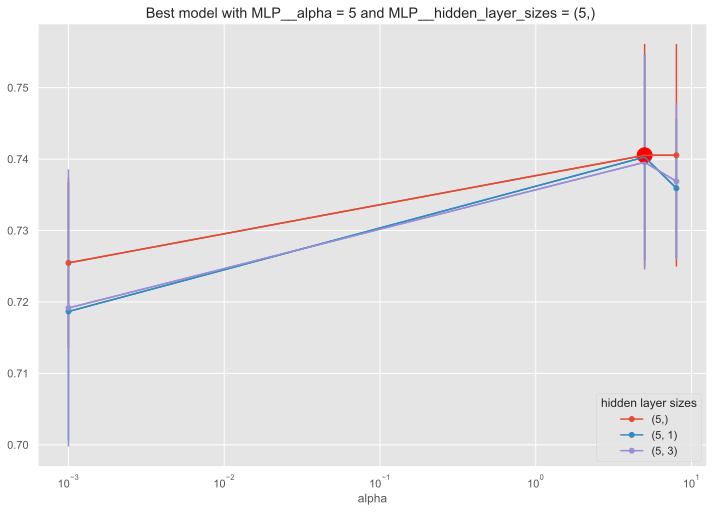

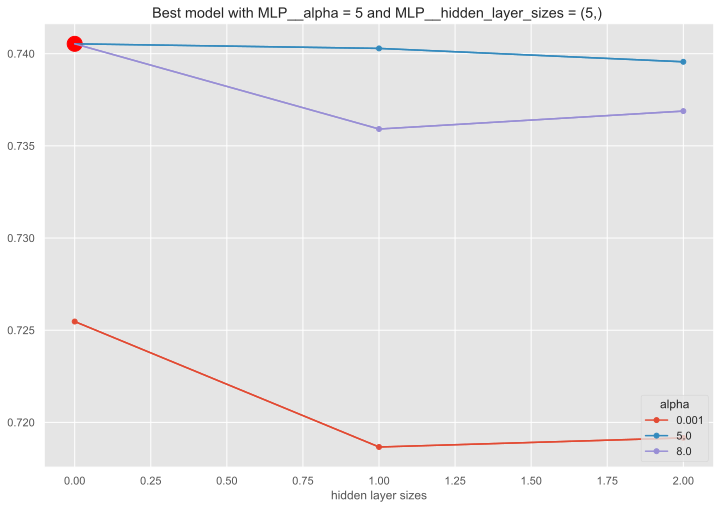

In [87]:
MT.plotModelGridError(MLP_fit, xscale="log")

In [119]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_.named_steps['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [120]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [121]:
sensmlp.summary()

Sensitivity analysis of [10, 5, 1] MLP network.

Sensitivity measures of each output:

$ExternalRiskEstimate 

                                   mean       std  mean_squared
ExternalRiskEstimate          -0.096136  0.048046      0.107474
NetFractionRevolvingBurden     0.065003  0.032297      0.072585
AverageMInFile                -0.058973  0.030860      0.066559
MSinceOldestTradeOpen          0.004271  0.009681      0.010582
PercentTradesWBalance          0.003745  0.008679      0.009452
PercentInstallTrades           0.024249  0.012472      0.027268
NumSatisfactoryTrades         -0.031479  0.020096      0.037347
NumTotalTrades                -0.014644  0.012147      0.019026
PercentTradesNeverDelq        -0.048873  0.032635      0.058768
MSinceMostRecentInqexcl7daysN -0.070111  0.032921      0.077455


In [122]:
sensmlp.info()

Sensitivity analysis of [10, 5, 1] MLP network.

4116 samples

Sensitivities of each output (only 5 first samples):

$ExternalRiskEstimate 

   ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
0             -0.138118                    0.081728       -0.061299   
1             -0.035221                    0.028194       -0.017041   
2             -0.128353                    0.084229       -0.062361   
3             -0.075763                    0.051703       -0.058985   
4             -0.012112                    0.007562       -0.008879   

   MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
0               0.021773               0.005380              0.025335   
1               0.008105              -0.008578              0.004773   
2               0.016640              -0.000782              0.019559   
3              -0.014092               0.010062              0.023483   
4              -0.002909               0.001509              0.0038

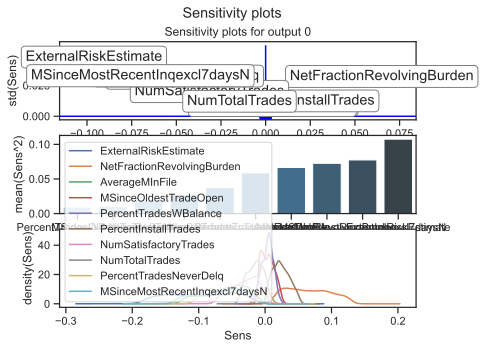

In [123]:
sensmlp.plot()

In [124]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]

### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  MSinceMostRecentInqexcl7daysN  \
7070                    1-6Months                       1.467896   
4049              Greater12Months                       2.657200   
3664                    1-6Months                       0.666009   
3008                    1-6Months                       0.000100   
6137                   Less1Month                     -16.491216   

      lessthan1Month_num RiskPerformance Y_MLP_pred  Y_MLP_prob_neg  \
7070                   0             YES         NO        0.602847   
4049                   0             YES         NO        0.871013   
3664                   0              NO         NO        0.716722   
3008                   0             YES        YES        0.259588   
6137                   1             YES        YES        0.054767   

      Y_MLP_prob_pos  
7070        0.397153  
4049        0.128987  
3664        0.283278  
3008        0.740412  
6137        0.945233

In [125]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_MLP_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1453  552
      YES  513 1598

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.24
Sensitivity: 0.76
Specificity: 0.72
Precision: 0.74
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [126]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_MLP_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 341  160
      YES 124  404

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.04
Sensitivity: 0.77
Specificity: 0.68
Precision: 0.73
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.72
F1 Score: 0.71
Positive label: NO


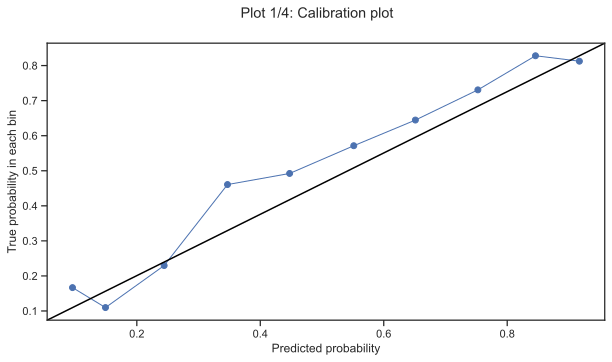

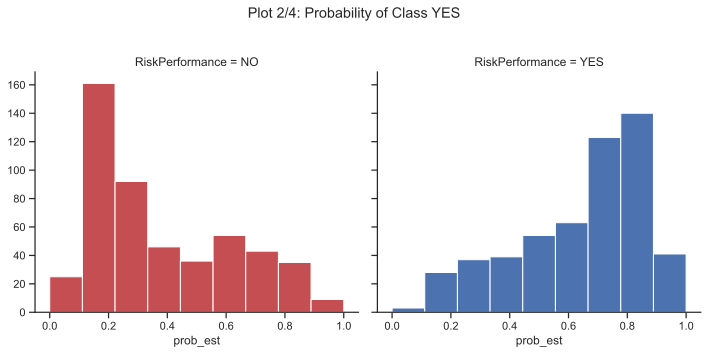

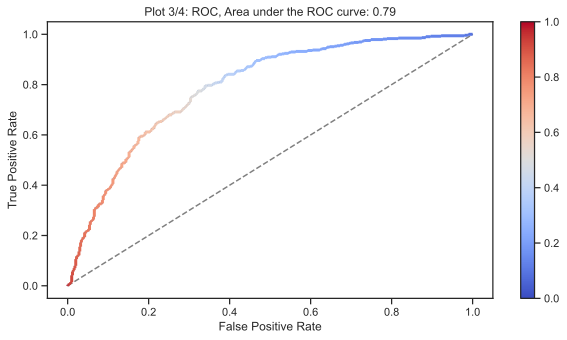

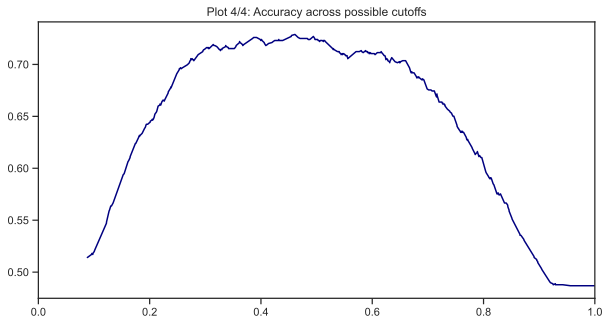

In [127]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass='YES')

-----------------------------------------------------------------------------------------------------------------

Hemos puesto originalmente el para probar distintos parametros de alpha numero de neuronas y capas ocultas. Primero obtenemos una estimación de donde se encontraria el optimo para las 3, para posteriormente aumentar el número de folds para obtener una precisión mas precisa. 

In [52]:
# Inputs of the model. Change accordingly to perform variable selection

# Define input and output matrices

vars_eliminate = ['MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades', 'MSinceMostRecentInqexcl7daysN']
INPUTS2_MLP = INPUTS_NUM.copy() # We use this subset due to the importance of the dummy Less1Month. It has been created for this model
for var in vars_eliminate:
    INPUTS2_MLP.remove(var)

In [53]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------

param = {'MLP__alpha': [1e-3, 5, 8], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,), (5,3), (5,5)]} # Number of neurons in each hidden layer, enters as tuples
#param = {'MLP__alpha': [0], # L2 regularization term 
#         'MLP__hidden_layer_sizes':[(20,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function adam para cuando pete 
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=150,
                                             verbose = True))]) # For replication
 
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS2_MLP], y_train) # Search in grid

print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01895D-01    |proj g|=  3.72228D-02

At iterate    1    f=  6.67911D-01    |proj g|=  1.03525D-01

At iterate    2    f=  6.19410D-01    |proj g|=  5.38167D-02

At iterate    3    f=  5.68113D-01    |proj g|=  5.16495D-02

At iterate    4    f=  5.49863D-01    |proj g|=  4.11340D-02

At iterate    5    f=  5.38872D-01    |proj g|=  9.25531D-03

At iterate    6    f=  5.37247D-01    |proj g|=  3.52362D-03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At iterate    7    f=  5.36361D-01    |proj g|=  6.82942D-03

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01683D-01    |proj g|=  3.69162D-02

At iterate    8    f=  5.35735D-01    |proj g|=  4.79479D-03

At iterate    1    f=  6.67714D-01    |proj g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


1306D-01    |proj g|=  3.21999D-03

At iterate    7    f=  5.40437D-01    |proj g|=  7.11425D-03

At iterate   13    f=  5.32565D-01    |proj g|=  4.15761D-03

At iterate    8    f=  5.39811D-01    |proj g|=  5.34615D-03

At iterate    9    f=  5.38995D-01    |proj g|=  2.66171D-03

At iterate   14    f=  5.32213D-01    |proj g|=  1.97450D-03

At iterate   15    f=  5.31994D-01    |proj g|=  2.30812D-03

At iterate   16    f=  5.31745D-01    |proj g|=  1.23533D-03

At iterate   17    f=  5.31149D-01    |proj g|=  6.81513D-03

At iterate   18    f=  5.30568D-01    |proj g|=  4.77136D-03

At iterate   19    f=  5.30130D-01    |proj g|=  1.11654D-03

At iterate   10    f=  5.38276D-01    |proj g|=  4.69683D-03

At iterate   11    f=  5.37770D-01    |proj g|=  5.72558D-03

At iterate   20    f=  5.30031D-01    |proj g|=  1.17925D-03

At iterate   12    f=  5.37043D-01    |proj g|=  2.97702D-03

At iterate   21    f=  5.29876D-01    |proj g|=  1.28473D-03

At iterate   13    f=  5.36445D-01

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


=  5.24454D-01    |proj g|=  4.59614D-04

At iterate   26    f=  5.26951D-01    |proj g|=  8.62593D-04

At iterate   27    f=  5.26820D-01    |proj g|=  2.51169D-03

At iterate  318    f=  5.21259D-01    |proj g|=  5.29669D-04

At iterate   56    f=  5.35935D-01    |proj g|=  8.82847D-04

At iterate  319    f=  5.21255D-01    |proj g|=  6.54222D-04

At iterate   57    f=  5.35766D-01    |proj g|=  8.86171D-04

At iterate  320    f=  5.21247D-01    |proj g|=  1.07398D-03




At iterate   58    f=  5.35727D-01    |proj g|=  2.74922D-03
At iterate  321    f=  5.21241D-01    |proj g|=  1.07961D-03

At iterate   28    f=  5.26646D-01    |proj g|=  2.79691D-03
At iterate   59    f=  5.35621D-01    |proj g|=  2.27267D-03

At iterate  322    f=  5.21233D-01    |proj g|=  3.61482D-04

At iterate   60    f=  5.35386D-01    |proj g|=  5.21877D-04
At iterate  285    f=  5.24449D-01    |proj g|=  5.95452D-04

At iterate   61    f=  5.35294D-01    |proj g|=  8.44531D-04

At iterate   62    f=  5.352

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   68    f=  5.22068D-01    |proj g|=  7.14740D-04

At iterate  110    f=  5.32796D-01    |proj g|=  6.98039D-04

At iterate   69    f=  5.21971D-01    |proj g|=  5.18220D-04

At iterate  111    f=  5.32761D-01    |proj g|=  9.73153D-04

At iterate  112    f=  5.32701D-01    |proj g|=  8.79984D-04

At iterate   70    f=  5.21873D-01    |proj g|=  1.23991D-03

At iterate  378    f=  5.21052D-01    |proj g|=  8.04686D-04

At iterate  113    f=  5.32672D-01    |proj g|=  2.19381D-03

At iterate  114    f=  5.32623D-01    |proj g|=  1.43715D-03

At iterate  379    f=  5.21050D-01    |proj g|=  8.42494D-04

At iterate  115    f=  5.32581D-01    |proj g|=  4.47391D-04

At iterate  116    f=  5.32565D-01    |proj g|=  4.47630D-04

At iterate  338    f=  5.24357D-01    |proj g|=  3.73439D-04

At iterate  117    f=  5.32556D-01    |proj g|=  4.96289D-04

At iterate  339    f=  5.24357D-01    |proj g|=  2.36889D-04


At iterate   71    f=  5.21841D-01    |proj g|=  1.15030D-03

At iter

 This problem is unconstrained.


 f=  5.11791D-01    |proj g|=  7.21391D-04

At iterate   49    f=  5.28315D-01    |proj g|=  1.52200D-03

At iterate  218    f=  5.11764D-01    |proj g|=  4.54798D-04

At iterate  219    f=  5.11747D-01    |proj g|=  1.09375D-03

At iterate   50    f=  5.28224D-01    |proj g|=  8.40803D-04

At iterate  220    f=  5.11729D-01    |proj g|=  6.86825D-04

At iterate   31    f=  5.33863D-01    |proj g|=  2.89268D-03

At iterate   75    f=  5.23155D-01    |proj g|=  5.12359D-04

At iterate   32    f=  5.33092D-01    |proj g|=  3.81143D-03

At iterate   33    f=  5.32595D-01    |proj g|=  2.69977D-03

At iterate   76    f=  5.23138D-01    |proj g|=  1.52815D-03

At iterate   77    f=  5.23114D-01    |proj g|=  1.35765D-03

At iterate   78    f=  5.23028D-01    |proj g|=  8.41372D-04

At iterate  221    f=  5.11714D-01    |proj g|=  3.20321D-04

At iterate   79    f=  5.22952D-01    |proj g|=  1.19237D-03

At iterate  222    f=  5.11698D-01    |proj g|=  2.87120D-04

At iterate  223    f=  5.1

 This problem is unconstrained.


g|=  1.41234D-03

At iterate   92    f=  5.23665D-01    |proj g|=  5.18858D-04

At iterate  262    f=  5.10043D-01    |proj g|=  6.84078D-04

At iterate   77    f=  5.26218D-01    |proj g|=  1.71775D-03

At iterate  119    f=  5.20631D-01    |proj g|=  2.91651D-03

At iterate   93    f=  5.23560D-01    |proj g|=  7.72165D-04

At iterate  263    f=  5.09980D-01    |proj g|=  1.26738D-03

At iterate   78    f=  5.26153D-01    |proj g|=  7.84916D-04

At iterate  120    f=  5.20531D-01    |proj g|=  1.62561D-03




At iterate  264    f=  5.09907D-01    |proj g|=  1.43497D-03
At iterate   79    f=  5.26124D-01    |proj g|=  5.15024D-04
At iterate   94    f=  5.23498D-01    |proj g|=  1.81391D-03
At iterate  121    f=  5.20458D-01    |proj g|=  5.42310D-04

At iterate   80    f=  5.26058D-01    |proj g|=  8.27539D-04

At iterate  265    f=  5.09737D-01    |proj g|=  1.96175D-03

At iterate   95    f=  5.23430D-01    |proj g|=  2.76880D-03

At iterate  122    f=  5.20423D-01    |proj g|=  6.8

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


65D-01    |proj g|=  1.46810D-03

At iterate  323    f=  5.15100D-01    |proj g|=  5.96726D-04

At iterate   48    f=  5.36352D-01    |proj g|=  1.99031D-03

At iterate  363    f=  5.13426D-01    |proj g|=  8.41720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient



F     = final function value
At iterate  323    f=  5.11948D-01    |proj g|=  2.37156D-03

At iterate  324    f=  5.15081D-01    |proj g|=  5.45474D-04
           * * *
At iterate   49    f=  5.36153D-01    |proj g|=  2.04435D-03

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   62    363    402      1     0     0   8.417D-05   5.134D-01
  F =  0.51342645915220797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


At iterate  325 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


At iterate  111    f=  5.24576D-01    |proj g|=  8.75886D-04

At iterate  233    f=  5.13852D-01    |proj g|=  8.56977D-04

At iterate  316    f=  5.25581D-01    |proj g|=  9.93174D-04

At iterate  106    f=  5.28126D-01    |proj g|=  4.72707D-04

At iterate  112    f=  5.24518D-01    |proj g|=  3.85689D-03

At iterate  234    f=  5.13782D-01    |proj g|=  1.46359D-03

At iterate  107    f=  5.28111D-01    |proj g|=  5.80659D-04

At iterate  113    f=  5.24442D-01    |proj g|=  1.78528D-03

At iterate  317    f=  5.25555D-01    |proj g|=  1.40780D-03

At iterate  235    f=  5.13737D-01    |proj g|=  1.12688D-03

At iterate  108    f=  5.28048D-01    |proj g|=  1.06857D-03

At iterate  114    f=  5.24391D-01    |proj g|=  6.91263D-04

At iterate  318    f=  5.25527D-01    |proj g|=  8.62334D-04

At iterate  236    f=  5.13666D-01    |proj g|=  9.60640D-04

At iterate  109    f=  5.28015D-01    |proj g|=  4.21706D-03

At iterate  115    f=  5.24360D-01    |proj g|=  6.18768D-04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate  181    f=  5.20648D-01    |proj g|=  1.72699D-03

At iterate  176    f=  5.24893D-01    |proj g|=  2.58585D-03

At iterate  304    f=  5.09865D-01    |proj g|=  3.36671D-04

At iterate  403    f=  5.24643D-01    |proj g|=  6.73217D-04

At iterate  182    f=  5.20511D-01    |proj g|=  1.60525D-03

At iterate  177    f=  5.24701D-01    |proj g|=  8.86980D-04

At iterate  404    f=  5.24635D-01    |proj g|=  5.13355D-04

At iterate  305    f=  5.09855D-01    |proj g|=  1.94591D-04

At iterate  183    f=  5.20453D-01    |proj g|=  1.81706D-03

At iterate  178    f=  5.24615D-01    |proj g|=  1.45809D-03

At iterate  405    f=  5.24627D-01    |proj g|=  5.81146D-04

At iterate  306    f=  5.09841D-01    |proj g|=  3.29332D-04

At iterate  184    f=  5.20376D-01    |proj g|=  7.02248D-04

At iterate  179    f=  5.24588D-01    |proj g|=  2.78998D-03

At iterate  307    f=  5.09812D-01    |proj g|=  3.67754D-04

At iterate  185    f=  5.20335D-01    |proj g|=  6.76296D-04

At itera

 This problem is unconstrained.


At iterate  376    f=  5.08301D-01    |proj g|=  4.93977D-04

At iterate  251    f=  5.17350D-01    |proj g|=  6.52108D-04

At iterate   12    f=  5.43967D-01    |proj g|=  3.83061D-03

At iterate  248    f=  5.21827D-01    |proj g|=  8.12003D-04

At iterate  252    f=  5.17318D-01    |proj g|=  6.19740D-04

At iterate  377    f=  5.08293D-01    |proj g|=  2.78771D-04

At iterate   13    f=  5.43323D-01    |proj g|=  4.06760D-03

At iterate  249    f=  5.21725D-01    |proj g|=  8.80351D-04

At iterate  253    f=  5.17260D-01    |proj g|=  1.89918D-03

At iterate  378    f=  5.08285D-01    |proj g|=  2.69011D-04

At iterate   14    f=  5.42501D-01    |proj g|=  8.77555D-03

At iterate  250    f=  5.21600D-01    |proj g|=  1.37437D-03

At iterate  254    f=  5.17219D-01    |proj g|=  9.88081D-04

At iterate  379    f=  5.08275D-01    |proj g|=  2.74518D-04

At iterate   15    f=  5.41244D-01    |proj g|=  4.38868D-03

At iterate  255    f=  5.17160D-01    |proj g|=  9.02860D-04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


   f=  5.37944D-01    |proj g|=  4.54634D-03

At iterate  255    f=  5.21152D-01    |proj g|=  1.58481D-03

At iterate  259    f=  5.16983D-01    |proj g|=  8.43991D-04

At iterate   21    f=  5.37377D-01    |proj g|=  3.15685D-03

At iterate  385    f=  5.08218D-01    |proj g|=  2.01735D-04


At iterate  260    f=  5.16929D-01    |proj g|=  9.57249D-04
At iterate  256    f=  5.21126D-01    |proj g|=  1.91160D-03


At iterate   22    f=  5.37053D-01    |proj g|=  5.91941D-03
At iterate  386    f=  5.08211D-01    |proj g|=  5.84658D-04

At iterate  261    f=  5.16874D-01    |proj g|=  8.04295D-04


At iterate   23    f=  5.36812D-01    |proj g|=  2.50418D-03
At iterate  387    f=  5.08201D-01    |proj g|=  1.82975D-04

At iterate  257    f=  5.21084D-01    |proj g|=  1.59449D-03

At iterate  262    f=  5.16766D-01    |proj g|=  1.04334D-03


At iterate   24    f=  5.36566D-01    |proj g|=  2.66121D-03
At iterate  388    f=  5.08196D-01    |proj g|=  1.16542D-04

At iterate  263    f=  5

 This problem is unconstrained.


At iterate   49    f=  5.43170D-01    |proj g|=  2.17108D-04

At iterate  172    f=  5.32352D-01    |proj g|=  1.02482D-03

At iterate   50    f=  5.43157D-01    |proj g|=  1.64102D-04

At iterate   47    f=  5.39495D-01    |proj g|=  4.29034D-04

At iterate   51    f=  5.43143D-01    |proj g|=  2.25596D-04

At iterate   48    f=  5.39489D-01    |proj g|=  2.10050D-04

At iterate  259    f=  5.19782D-01    |proj g|=  2.05490D-03

At iterate   52    f=  5.43136D-01    |proj g|=  4.17244D-04

At iterate  260    f=  5.19729D-01    |proj g|=  1.92812D-03

At iterate   49    f=  5.39479D-01    |proj g|=  2.51658D-04

At iterate  261    f=  5.19701D-01    |proj g|=  5.85195D-03

At iterate   50    f=  5.39465D-01    |proj g|=  3.52794D-04

At iterate   53    f=  5.43127D-01    |proj g|=  2.31650D-04

At iterate  262    f=  5.19641D-01    |proj g|=  2.10042D-03

At iterate   51    f=  5.39437D-01    |proj g|=  9.42689D-04

At iterate  173    f=  5.32327D-01    |proj g|=  1.53142D-03

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase t


At iterate  436    f=  5.12840D-01    |proj g|=  1.87897D-03

At iterate  340    f=  5.25676D-01    |proj g|=  2.49953D-03

At iterate   47    f=  5.55580D-01    |proj g|=  1.62348D-04

At iterate  341    f=  5.25657D-01    |proj g|=  4.37165D-03

At iterate   48    f=  5.55577D-01    |proj g|=  1.20171D-04

At iterate  342    f=  5.25625D-01    |proj g|=  2.05268D-03

At iterate  437    f=  5.12810D-01    |proj g|=  1.65465D-03

At iterate  343    f=  5.25609D-01    |proj g|=  8.90368D-04

At iterate   49    f=  5.55576D-01    |proj g|=  2.97925D-04

At iterate  438    f=  5.12781D-01    |proj g|=  2.14129D-03

At iterate   50    f=  5.55573D-01    |proj g|=  2.13613D-04

At iterate  439    f=  5.12727D-01    |proj g|=  2.60655D-03

At iterate  344    f=  5.25594D-01    |proj g|=  9.74690D-04

At iterate   51    f=  5.55572D-01    |proj g|=  8.58969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


f=  5.63007D-01    |proj g|=  1.37392D-04

At iterate  415    f=  5.23140D-01    |proj g|=  1.61809D-03

At iterate   48    f=  5.63004D-01    |proj g|=  7.28579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   62     48     62      1     0     0   7.286D-05   5.630D-01
  F =  0.56300439921425238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate  416    f=  5.23103D-01    |proj g|=  1.45678D-03

At iterate  417    f=  5.23083D-01    |proj g|=  1.98747D-03

At iterate   51    f=  5.58068D-01    |proj g|=  4.24254D-04

At iterate   52    f=  5.58064D-01    |proj g|=  2.45278D-04

At itera

 This problem is unconstrained.
 This problem is unconstrained.


1D-01    |proj g|=  9.90420D-04

At iterate   26    f=  5.51760D-01    |proj g|=  2.57597D-03

At iterate   19    f=  5.59220D-01    |proj g|=  1.26667D-03

At iterate   27    f=  5.51668D-01    |proj g|=  4.42751D-04

At iterate   20    f=  5.58922D-01    |proj g|=  5.18008D-04

At iterate   23    f=  5.55863D-01    |proj g|=  8.12300D-04

At iterate   28    f=  5.51612D-01    |proj g|=  8.00651D-04

At iterate   21    f=  5.58677D-01    |proj g|=  1.84709D-03

At iterate   24    f=  5.55845D-01    |proj g|=  4.39010D-04

At iterate   29    f=  5.51559D-01    |proj g|=  8.49277D-04


At iterate   25    f=  5.55829D-01    |proj g|=  3.93427D-04
At iterate   22    f=  5.58636D-01    |proj g|=  4.30028D-03

At iterate   30    f=  5.51519D-01    |proj g|=  1.54461D-03

At iterate   26    f=  5.55776D-01    |proj g|=  7.45363D-04

At iterate   31    f=  5.51413D-01    |proj g|=  7.00008D-04

At iterate   23    f=  5.58541D-01    |proj g|=  3.99650D-04

At iterate   27    f=  5.55708D-01   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   68    f=  5.67719D-01    |proj g|=  1.50107D-04

At iterate   40    f=  5.72918D-01    |proj g|=  4.46388D-04

At iterate   41    f=  5.72906D-01    |proj g|=  1.30189D-03

At iterate   69    f=  5.67716D-01    |proj g|=  3.92695D-04

At iterate   42    f=  5.72887D-01    |proj g|=  2.14167D-04

At iterate   70    f=  5.67714D-01    |proj g|=  6.94056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   76     70     81      1     0     0   6.941D-05   5.677D-01
  F =  0.56771390057074145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate   43    f=  5.72880D-01    |proj g|=  2

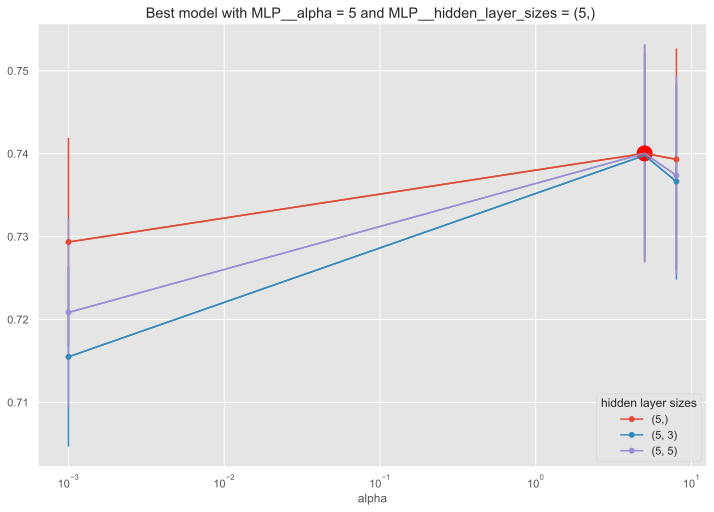

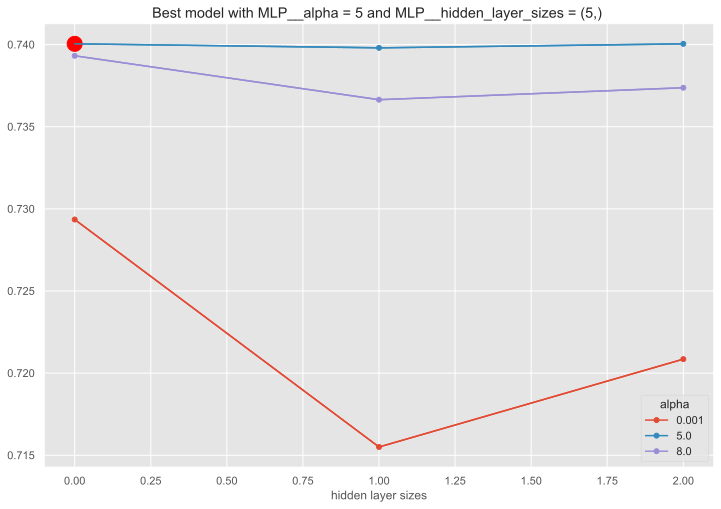

In [54]:
MT.plotModelGridError(MLP_fit, xscale="log")

In [55]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_.named_steps['scaler'].transform(X_train[INPUTS2_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS2_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS2_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

Empty DataFrame
Columns: [ExternalRiskEstimate, NetFractionRevolvingBurden, AverageMInFile, PercentInstallTrades, NumSatisfactoryTrades, PercentTradesNeverDelq, lessthan1Month_num]
Index: []

In [56]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS2_MLP], y, use_torch=False)

In [107]:
sensmlp.summary()

Sensitivity analysis of [7, 5, 1] MLP network.

Sensitivity measures of each output:

$ExternalRiskEstimate 

                                mean       std  mean_squared
ExternalRiskEstimate       -0.097783  0.049215      0.109469
NetFractionRevolvingBurden  0.066682  0.032257      0.074074
AverageMInFile             -0.056213  0.029870      0.063657
PercentInstallTrades        0.024676  0.011901      0.027396
NumSatisfactoryTrades      -0.042825  0.024668      0.049421
PercentTradesNeverDelq     -0.046921  0.030081      0.055736
lessthan1Month_num          0.070041  0.033072      0.077456


In [97]:
sensmlp.info()

Sensitivity analysis of [7, 5, 1] MLP network.

4116 samples

Sensitivities of each output (only 5 first samples):

$ExternalRiskEstimate 

   ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
0             -0.138768                    0.076624       -0.047024   
1             -0.038713                    0.029317       -0.013371   
2             -0.121359                    0.074597       -0.048259   
3             -0.086861                    0.064548       -0.075477   
4             -0.010065                    0.009564       -0.012901   

   PercentInstallTrades  NumSatisfactoryTrades  PercentTradesNeverDelq  \
0              0.027465              -0.062567               -0.093776   
1              0.005585              -0.030666               -0.036755   
2              0.019738              -0.040446               -0.083155   
3              0.027206              -0.008817               -0.009353   
4              0.004285              -0.000946                0

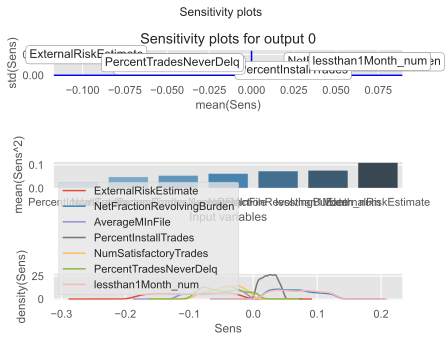

In [98]:
sensmlp.plot()

In [99]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP2_pred'] = MLP_fit.predict(X_train[INPUTS2_MLP])
dfTR_eval['Y_MLP2_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS2_MLP])[:,0]
dfTR_eval['Y_MLP2_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS2_MLP])[:,1]

### Scale test using preprocess in training
dfTS_eval['Y_MLP2_pred'] = MLP_fit.predict(X_test[INPUTS2_MLP])
dfTS_eval['Y_MLP2_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS2_MLP])[:,0]
dfTS_eval['Y_MLP2_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS2_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216                     31                    31   
4049                    238                     33                    35   
3664                    277                     64                    36   
3008                    168                     71                    25   
6137                     61                    100                    67   

      NumSatisfactoryTrades  NumTotalTrades  PercentTradesNeverDelq  \
7070                     25              26            1.092590e+13   
4049                     22              23            2.434181e+13   
3664                     32              36            1.931905e+13   
3008                     33              37            7.721268e+12   
6137                      9               9            1.521567e+13   

     MSinceMostRecentInqexcl7days  MSinceMostRecentInqexcl7daysN  \
7070                    1-6Months                       1.467896   
4049              Greater12Months                       2.657200   
3664                    1-6Months                       0.666009   
3008                    1-6Months                       0.000100   
6137                   Less1Month                     -16.491216   

      lessthan1Month_num RiskPerformance Y_LR_pred  Y_LR_prob_neg  \
7070                   0             YES        NO       0.612584   
4049                   0             YES        NO       0.901065   
3664                   0              NO        NO       0.704087   
3008                   0             YES       YES       0.267271   
6137                   1             YES       YES       0.038554   

      Y_LR_prob_pos Y_MLP2_pred  Y_MLP2_prob_neg  Y_MLP2_prob_pos  
7070       0.387416          NO         0.594718         0.405282  
4049       0.098935          NO         0.862146         0.137854  
3664       0.295913          NO         0.723327         0.276673  
3008       0.732729         YES         0.259363         0.740637  
6137       0.961446         YES         0.055543         0.944457

In [100]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_MLP2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1454  551
      YES  510 1601

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.22
Sensitivity: 0.76
Specificity: 0.73
Precision: 0.74
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [101]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_MLP2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 344  157
      YES 124  404

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.06
Sensitivity: 0.77
Specificity: 0.69
Precision: 0.74
Recall: 0.69
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.73
F1 Score: 0.71
Positive label: NO


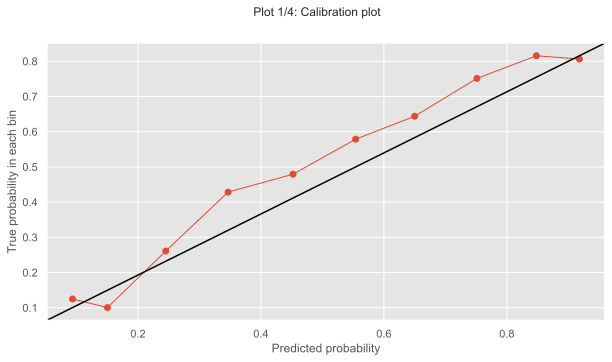

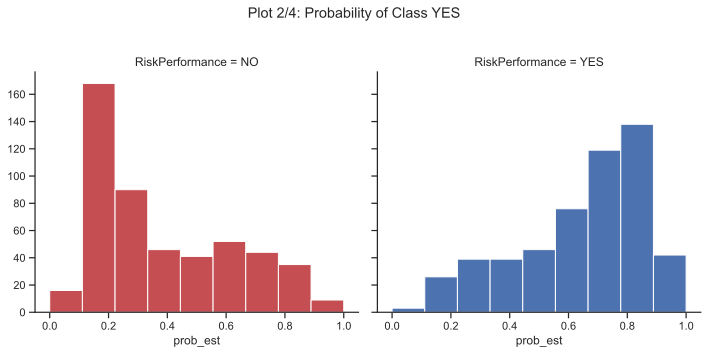

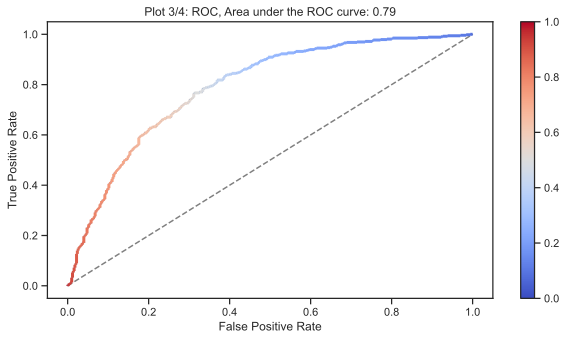

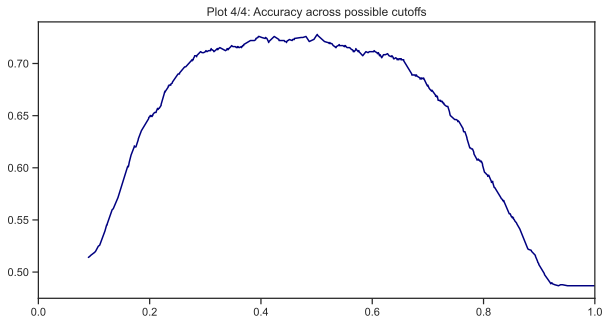

In [102]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], MLP_fit.predict_proba(X_test[INPUTS2_MLP]), selClass='YES')